# Анализ настроений в Twitter
**Анализ настроений** - это раздел обработки естественного языка *(Natural Language Processing)*, который позволяет нам определить, является ли строка текста положительной или отрицательной. Анализ настроений данных социальных сетей важен с точки зрения бизнеса, поскольку он позволяет организациям анализировать тенденции в общественном мнении. Эта информация может мотивировать изменения в бизнес-стратегиях для решения проблем, связанных с низким уровнем удовлетворенности клиентов.

**Цель:** разработать классификатор, способный отличать твиты с позитивными настроениями от твитов с негативными настроениями. Классификатор будет обучен на основе общего текста твитов, а затем протестирован на отдельном наборе данных, состоящем только из твитов, касающихся авиакомпаний, чтобы продемонстрировать обобщаемость модели в бизнес-контексте. Естественно, что распределения слов и метки различаются между обоими наборами данных, поэтому управление переоборудованием будет сложной задачей. Проанализировав эти данные, определим, что говорит общественное мнение в Twitter о американских авиакомпаниях.

Будут использованы два набора данных, собранных из интернета:
- `generic_tweets.txt`  содержит общие твиты, которые уже были помечены своим настроением (позитивным/негативным). <br>200000 твитов были отобраны из https://www.kaggle.com/kazanova/sentiment140

- `US_airline_tweets.csv`  содержит твиты, касающиеся различных авиакомпаний США 
<br> https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_rows=15
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import time
import pickle
import joblib
from tqdm.notebook import tqdm
from scipy.sparse.csr import csr_matrix

import re
from bs4 import BeautifulSoup 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_curve, classification_report,
                             roc_auc_score, f1_score, plot_confusion_matrix,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier
import xgboost as xgb

from gensim.models import KeyedVectors, Word2Vec 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, callbacks, optimizers

### Описание столбцов `generic_tweets.txt`:
- **class**: полярность настроения твита (0=negative, 4=positive)
- **id**   : уникальный id твита
- **date** : дата твита
- **query**: запрос
- **user** : имя автора твита
- **text** : текст твита

In [5]:
generic_df = pd.read_csv('datasets/generic_tweets.txt', sep=',', header=0) 
generic_df.head() 

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
generic_df.shape

(200000, 6)

In [7]:
generic_df.dtypes

class     int64
id        int64
date     object
query    object
user     object
text     object
dtype: object

### Описание столбцов `US_airline_tweets.csv` :
- **id**   : уникальный id твита
- **sentiment**: полярность настроения твита (negative, positive)
- **negative_reason**: причина негативных твитов (оставлено пустым для положительных твитов)
- **retweet_count**: количество ретвитов
- **user** : имя автора твита
- **text** : текст твита

In [8]:
airline_df = pd.read_csv('datasets/US_airline_tweets.csv',header=0) 
airline_df.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


In [9]:
airline_df.shape

(11541, 6)

In [10]:
airline_df.dtypes

id                 float64
sentiment           object
negative_reason     object
user                object
retweet_count        int64
text                object
dtype: object

Твиты не готовы к анализу, так как существует слишком много шума. Чтобы удалить шум из каждого твита, нам нужно предварительно обработать его, очистить перед анализом.

Функция `cleanTweet()`, которая принимает текст твита в качестве входных данных и выполняет следующие операции перед его возвратом:
- Удаляет HTML-теги и атрибуты, а также преобразует коды символов HTML в ASCII с помощью библиотеки BeautifulSoup
- Удаляет URL-Адреса
- Устанавливает все символы в тексте в нижний регистр
- Удаляет знаки препинания, кроме "@", так как они нужны нам для идентификации тегов twitter позже
- Удаляет стоп-слова
- Методы нормализации текста - лемматизация (пакет nltk)

In [11]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('running')

'running'

In [12]:
def cleanTweet(tweet):
    soup = BeautifulSoup(tweet)
    cleanTweet = soup.get_text()
    cleanTweet = re.sub(r'http\S+', '', cleanTweet)
    cleanTweet = re.sub(r'[^\w\s@]', '', cleanTweet)
    cleanTweet = cleanTweet.lower()
    
    # stopwords
    stoplist = set(stopwords.words('english'))
    cleanTweet_tokenized = word_tokenize(cleanTweet)
    tokenized_tweet_nostop = [word for word in cleanTweet_tokenized if word not in stoplist]
    
    # lemmatization
    tokenized_lemma = []
    lemmatizer = WordNetLemmatizer()
    for token in tokenized_tweet_nostop:
        token_lemma = lemmatizer.lemmatize(token)
        tokenized_lemma.append(token_lemma)     
    
    cleanTweet = " ".join(tokenized_lemma)
    cleanTweet = re.sub(r'(?<=@)\s(?=\w+)', '', cleanTweet) #удаляет пробелы между @ и именем
    return cleanTweet

In [13]:
airline_df['cleantext'] = airline_df['text'].apply(cleanTweet)
airline_df.head()

,id,sentiment,negative_reason,user,retweet_count,text,cleantext
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,@virginamerica plus youve added commercial exp...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,@virginamerica really aggressive blast obnoxio...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,@virginamerica really big bad thing
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,@virginamerica seriously would pay 30 flight s...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",@virginamerica yes nearly every time fly vx âœ...


In [14]:
generic_df['cleantext'] = generic_df['text'].apply(cleanTweet)
generic_df.head()

,class,id,date,query,user,text,cleantext
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",@switchfoot awww thats bummer shoulda got davi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan dived many time ball managed save 50...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",@nationwideclass behaving im mad cant see


## Исследовательский Анализ
Прежде чем начать применять какие-либо алгоритмы машинного обучения к наборам данных, будет проведен исследовательский анализ для ознакомления с данными.

Извлечение всех пользователей twitter, помеченных для каждого твита в фрейме данных авиакомпании США.

In [15]:
airline_df['class'] = airline_df['sentiment'].apply(lambda x: 4 if x=='positive' else 0)

In [16]:
textWords = airline_df['cleantext'].str.split()

tagged = []
alltags = []

for sentence in textWords:
    tagList = []
    for word in sentence:
        if '@' in word:
            atIndex = word.index('@') 
            onlyAlphaNum = re.sub(r'\W+', '', word[atIndex+1:])
            tagList.append(onlyAlphaNum)
            alltags.append(onlyAlphaNum)
    tagged.append(tagList)
    
taggedUsers    = pd.Series(tagged)
allTaggedUsers = pd.Series(alltags)
allTaggedUsers.value_counts().head(15)

united             3186
usairways          2606
americanair        2456
southwestair       1784
jetblue            1514
virginamerica       343
delta                60
imaginedragons       17
phlairport           17
dfwairport           12
fortunemagazine      10
spiritairlines        8
love_dragonss         7
cowboycerrone         7
cnn                   6
dtype: int64

Из подсчета тегов из всех твитов авиакомпаний видно, что крупнейшие авиакомпании, упомянутые во всех твитах, являются следующими:

- united
- usairways
- americanair
- southwestair
- jetblue 
- virginamerica 
- delta
- spiritairlines

Теперь мы можем определить каждый твит интересующей нас авиакомпании на основе одного из двух идентификаторов:
1. Тэг авиакомпании в твите
2. Имя пользователя твите


In [17]:
# поиск авиакомпании, для каждого твита ('авиакомпания' or 'None')
tweetAirline = []
for tweet in tagged:
    added = False
    for tag in tweet:
        # Проверка, начинается ли имя пользователя твита с ключевого слова для интересующей авиакомпании
        if tag.startswith('united'):
            tweetAirline.append('united')
            added = True;break
        elif tag.startswith('usairways'):
            tweetAirline.append('usairways')
            added = True;break
        elif tag.startswith('americanair'):
            tweetAirline.append('americanair')
            added = True;break
        elif tag.startswith('southwestair'):
            tweetAirline.append('southwestair')
            added = True;break
        elif tag.startswith('jetblue'):
            tweetAirline.append('jetblue')
            added = True;break
        elif tag.startswith('virginamerica'):
            tweetAirline.append('virginamerica')
            added = True;break
        elif tag.startswith('delta'):
            tweetAirline.append('delta')
            added = True;break
        elif tag.startswith('spiritairlines'):
            tweetAirline.append('spiritairlines')
            added = True;break
    if added == False:
        tweetAirline.append('None') 

In [18]:
airline_df['Airline'] = pd.Series(tweetAirline)
airline_df.head()

,id,sentiment,negative_reason,user,retweet_count,text,cleantext,class,Airline
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,@virginamerica plus youve added commercial exp...,4,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,@virginamerica really aggressive blast obnoxio...,0,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,@virginamerica really big bad thing,0,virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,@virginamerica seriously would pay 30 flight s...,0,virginamerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",@virginamerica yes nearly every time fly vx âœ...,4,virginamerica


In [19]:
airline_df['Airline'].value_counts()

united           3124
usairways        2532
americanair      2296
southwestair     1757
jetblue          1496
virginamerica     333
delta               2
None                1
Name: Airline, dtype: int64

In [20]:
airline_df[airline_df['Airline']=='None']

,id,sentiment,negative_reason,user,retweet_count,text,cleantext,class,Airline
6184,5.686020e+17,positive,NaN,JetBlue,3,@NinaDavuluri We think it's a treat to have yo...,@ninadavuluri think treat onboard enjoy flight ðÿ,4,None


Мы видим, что один твит не был назначен ни на одну авиакомпанию. Глядя на пользователя для твита, мы видим, что авиакомпания должна была быть назначена как "jetblue".

In [21]:
# для твитов, которые до сих пор не имеют назначенных авиакомпаний
# проверьте имя пользователя твита, чтобы узнать, указывает ли он на интересующую вас авиакомпанию
noneIndex = airline_df.index[airline_df['Airline']=='None']
airline_names = ['united','usairways','americanair','southwestair','jetblue','virginamerica','delta','spiritairlines']

for i in noneIndex:
    userID = airline_df.loc[i,'user'].lower()
    for airline in airline_names:
        if userID.startswith(airline):
            airline_df.loc[i,'Airline'] = airline
            break

In [22]:
airline_df['Airline'].value_counts()

united           3124
usairways        2532
americanair      2296
southwestair     1757
jetblue          1497
virginamerica     333
delta               2
Name: Airline, dtype: int64

In [23]:
assert(airline_df.shape[0] == airline_df['Airline'].value_counts().sum())

Конец классификации каждого твита по авиакомпании, теперь можно получить количество отрицательных и положительных твитов для каждой авиакомпании.

In [24]:
negPosCounts = airline_df.groupby(['sentiment'])['Airline'].value_counts()

# .reindex() метод позволяет установить значение счетчика равным 0, если нет никаких значений для подсчета
negCountSeries = negPosCounts['negative'].reindex(airline_df['Airline'].unique(), fill_value=0)
posCountSeries = negPosCounts['positive'].reindex(airline_df['Airline'].unique(), fill_value=0)

negPosCounts

sentiment  Airline      
negative   united           2632
           usairways        2263
           americanair      1960
           southwestair     1187
           jetblue           953
           virginamerica     181
           delta               2
positive   southwestair      570
           jetblue           544
           united            492
           americanair       336
           usairways         269
           virginamerica     152
Name: Airline, dtype: int64

In [25]:
print('Общее количество негативных твитов авиакомпании:\t' ,negCountSeries.sum())
print('Общее количество положительных твитов авиакомпании:\t', posCountSeries.sum())
print('Процент положительных твитов авиакомпаний:\t\t' , round(100*posCountSeries.sum()/(posCountSeries.sum()+negCountSeries.sum()),2) ,' %')

Общее количество негативных твитов авиакомпании:	 9178
Общее количество положительных твитов авиакомпании:	 2363
Процент положительных твитов авиакомпаний:		 20.47  %


### Визуализация настроений твитов авиакомпаний
Здесь представлена многослойная гистограмма количества положительных и отрицательных твитов для каждой авиакомпании. Это позволяет легко сравнивать общее количество твитов, а также соотношение положительных и отрицательных твитов, связанных с каждой авиакомпанией.

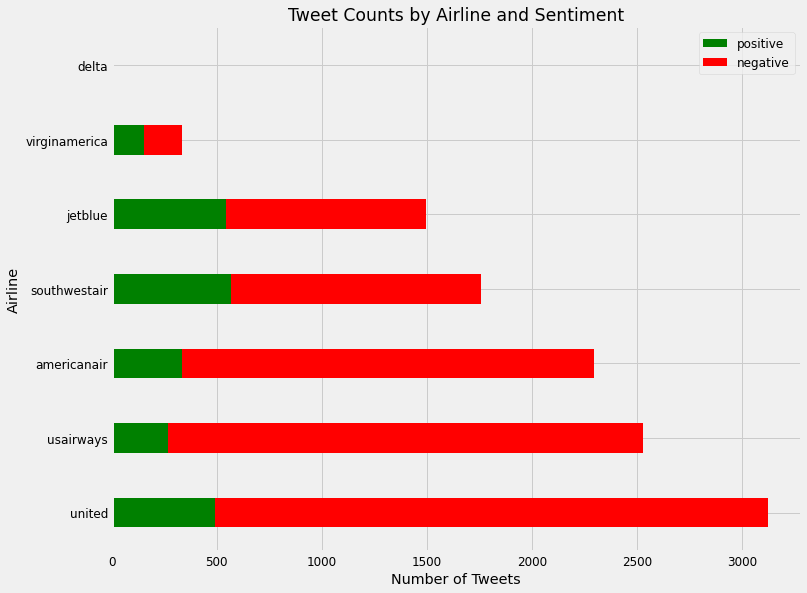

In [26]:
import matplotlib.style as style
style.use('fivethirtyeight')

airlineList = airline_df['Airline'].value_counts().index
N = len(airlineList)

posCount, negCount = [], []

for i in airlineList:
    posCount.append(posCountSeries[i])
    negCount.append(negCountSeries[i])
    
ind = np.arange(N)    # groups on x-axis
width = 0.4       # width of the bars

plt.rcParams['figure.figsize'] = [11, 9]
plt.rcParams.update({'font.size': 12})
p1 = plt.barh(ind, posCount, width, color='g')
p2 = plt.barh(ind, negCount, width, color='r',
             left=posCount)

plt.xlabel('Number of Tweets')
plt.ylabel('Airline')
plt.title('Tweet Counts by Airline and Sentiment')
plt.yticks(ind, airlineList)
plt.xticks(np.arange(0, 3201, 500))
plt.legend((p1[0], p2[0]), ('positive', 'negative'));

Только 20,5% всех твитов, касающихся авиакомпаний, были классифицированы как имеющие положительные настроения,  что указывает на то, что большинство твитов касалось жалоб авиакомпаний.

### Визуализация Жалоб Авиакомпаний
Каждый твит с негативными настроениями в наборе данных авиакомпании имеет причину для жалоб, связанных с ним. Мы можем сформировать частотный график жалоб, чтобы определить, с чем американские авиакомпании боролись больше всего.

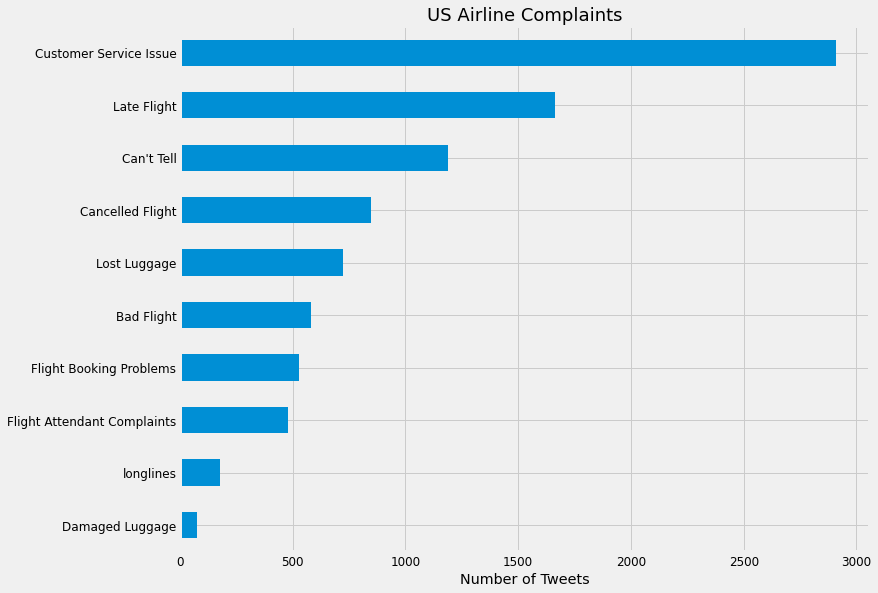

In [27]:
# Новый dataframe с негативными твитами авиакомпании
negativeAirline_df = airline_df[airline_df['sentiment']=='negative']
ax = negativeAirline_df['negative_reason'].value_counts(ascending=True).plot(kind='barh')
ax.set_title('US Airline Complaints', fontsize=18)
ax.set_xlabel('Number of Tweets')
plt.show()

### Частота слов для твитов авиакомпаний
Представлено облако слов, отображающее частоты лучших 200 слов в наборе данных twitter американской авиакомпании. Более крупные слова соответствуют более высокой частоте.

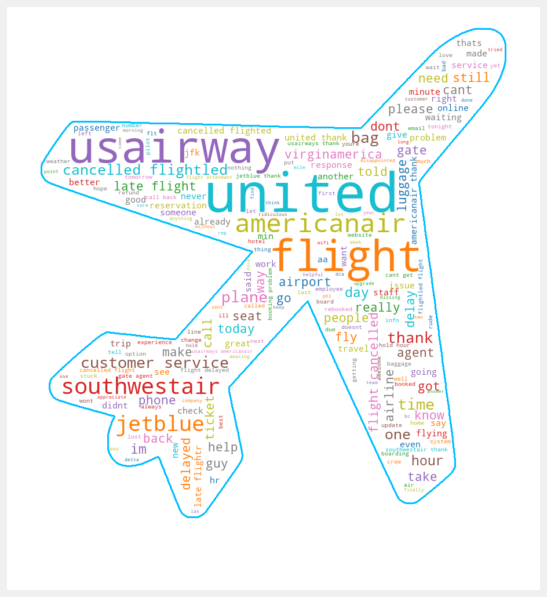

In [28]:
def generate_wordcloud(textSeries, mask_img):
    wcText = " ".join(tweet for tweet in textSeries)
    twitter_mask = np.array(Image.open(mask_img))
    twitter_mask[twitter_mask>240] = 255
    wordcloud = WordCloud(max_words=200,
                          background_color="white",
                          width=600,
                          height=600,
                          mask=twitter_mask,
                          colormap='tab10',
                          contour_color='deepskyblue',
                          contour_width=2
    ).generate(wcText)
    # Display the wordcloud
    plt.figure( figsize=(10,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plane_mask = 'misc/Planelogo_mask.png'
generate_wordcloud(airline_df['cleantext'], plane_mask)

Быстрый осмотр wordcloud показывает, что многие из твитов связаны со следующими компаниями: United Airlines, US airways и American Air. Значительная часть твитов связана с обслуживанием клиентов, задержками и отменами рейсов.

### Частоты слов в Twitter

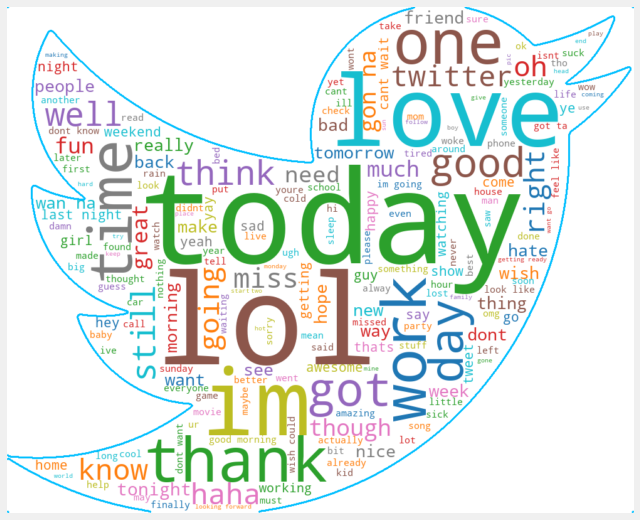

In [29]:
twitter_mask = 'misc/twitterlogo_mask.png'
generate_wordcloud(generic_df['cleantext'], twitter_mask)

Из облака слов очевидно, что некоторые из наиболее часто упоминаемых слов в твитах являются: любовь, лол, сегодня, время, работа, день, уход. Похоже, что многие пользователи twitter склонны писать о своем повседневном опыте, а также о том, что им нравится.

## Характеристика текста и выбор модели
Чтобы подготовить данные для ввода в модель, нужно преобразовать текстовые данные в числовые входные данные. Один из вариантов - преобразовать текстовых данные с помощью TF-IDF (обратная частота документа). Это позволяет каждому слову масштабироваться пропорционально количеству раз, когда оно появляется в документе (твит), и обратно пропорционально количеству раз, когда оно появляется в коллекции документов (различные твиты). Эта модель обычно более надежна, чем простая модель частоты слов (bag-of-words), поскольку важность слова уменьшается, если оно появляется в большем количестве твитов.

Кроме того, будет также выполнена характеристика с использованием word embedding. Word embedding эффективно кодируют каждое слово векторами, так что слова с похожим контекстом имеют высокое косинусное сходство (низкий угол между векторами).  Word embedding создаются с помощью неглубокой модели нейронной сети, причем обученные веса нейронной сети действуют как векторы слов. Будет задействована модель skip-gram (SG), так и модель continuous bag of words (CBOW). SG обучает однослойную нейронную сеть, основанную на задании заданного входного слова, дающего нам прогнозируемую вероятность появления других слов вблизи входа. CBOW, с другой стороны, принимает несколько входных контекстных слов, чтобы предсказать вероятность появления одного слова вокруг входных слов. Затем векторы слов для каждого слова в твите можно усреднить, чтобы получить один embedding вектор твита.

С word2vec, можно непосредственно кодировать каждый твит с помощью вектора документа изпользуя doc2vec. Реализация распределенного пакета слов (DBOW) doc2vec использует вектор документа для предсказания нескольких слов в абзаце. Реализация распределенной памяти (DM) использует несколько контекстных слов в окне, а также вектор документа для предсказания одного слова. Поскольку встраивание слов и документов использует неконтролируемый подход к обучению, обычно встраивание выполняется на максимально возможном количестве релевантных текстовых данных без разделения данных на обучающие и тестовые части.

Девять различных характеристик будут протестированы:
- unigram TF-IDF
- bigram TF-IDF
- trigram TF-IDF
- unigram & bigram TF-IDF
- unigram & bigram & trigram TF-IDF
- word2vec skip-gram (SG)
- word2vec continuous bag of words (CBOW)
- doc2vec distributed bag of words (DBOW)
- doc2vec distributed memory (DM)
   

Перед созданием характеристик набор данных случайным образом разбивается на обучающие и тестовые данные.

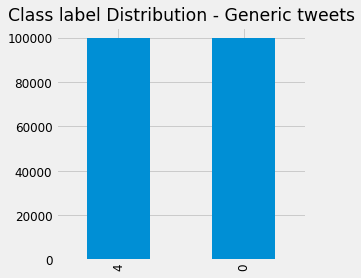

In [30]:
# Check balance
plt.figure(figsize=(4,4))
generic_df['class'].value_counts().plot(kind='bar')
plt.title('Class label Distribution - Generic tweets')
plt.show()

### Подготовка данных для обучения

In [31]:
cleanTweets     = generic_df['cleantext']
tweetSentiments = generic_df['class']
X_train, X_test, y_train, y_test = train_test_split(cleanTweets, tweetSentiments, 
                                                    test_size=.2, random_state=1, 
                                                    stratify=tweetSentiments)

<img src='https://user-images.githubusercontent.com/54672403/83495310-2fbfda80-a4c0-11ea-9253-dffea30b5bf0.png' width='500'>

In [29]:
#~~~~~~~~~~~| Текстовая характеристика обучающих данных |~~~~~~~~~~~#
X_train_featurizations = {}

# TF-IDF
def tfidf_featurize(X_untokenized):
    '''
    X_untokenized (list)
        серия не разбитыx на лексемы твитов
    return: featurizations (dict)
           tfidf трансформатор : преобразованный набор данных
    '''
    min_df_ = 5
    max_features_ = 3000
    tfidf_ngrams = {
        'tfidf_1g':(1,1),   # Unigram
        'tfidf_2g':(2,2),   # Bigram
        'tfidf_3g':(3,3),   # Trigram
        'tfidf_1g2g':(1,2), # Unigram + Bigram
        'tfidf_1g2g3g':(1,3), # Unigram + Bigram + Trigram
    } 
    
    featurizations = {} 
    for name, ngram_range_ in sorted(tfidf_ngrams.items()):
        tfidf_vectorizer = TfidfVectorizer(min_df=min_df_,
                                           max_features=max_features_,
                                           ngram_range=ngram_range_)
        X_transform = tfidf_vectorizer.fit_transform(X_untokenized)
        featurizations[name] = {'X': X_transform,
                               'transformer': tfidf_vectorizer}
    return featurizations

featurize_eval = tfidf_featurize(X_train)

<img src='https://user-images.githubusercontent.com/54672403/83497749-94306900-a4c3-11ea-8a96-440091bad975.png' width='500'>

In [30]:
#~~~~~~~~~~~| Word Embeddings - word2vec |~~~~~~~~~~~#
def get_mean_wordVec(tokenized_tweet, model_wv, vecSize):
    ''' return: усрднённое значение векторов слов в токенизированном твите'''
    avg_wordVec = np.zeros(vecSize).reshape((1, vecSize))
    count_inVocab = 0
    for token in tokenized_tweet:
        try:
            avg_wordVec   += model_wv[token].reshape((1, vecSize))
            count_inVocab += 1
        except KeyError:
            continue # token not in model_wv
            
    if count_inVocab != 0: avg_wordVec /= count_inVocab
    return avg_wordVec


def w2v_featurize(X_untokenized, wordVecs):
    '''
    X_untokenized (list)
        серия не разбитые на лексемы твитов для создания признаков word2vec
    wordVecs  (dict) - результат w2v_learn
        название трансформатора : обученная модель 
        word2vec embedded data  : word-to-vector mapping object
    
    return: featurizations (dict)
         название трансформатора : векторы признаков
         word2vec embedded data  : word-to-vector mapping object(s)
    '''
    featurizations= {}
    for modelName, wv in wordVecs.items():
        vec_size = wv.vectors.shape[1]
        X_tokenized = X_untokenized.copy().str.split()
        
        # Усреднение всех векторов слов в твите, чтобы получить вектор признаков для каждого твита
        X_transform = X_tokenized.apply(get_mean_wordVec, args=(wv, vec_size))
        featurizations[modelName] = {'X': np.concatenate(X_transform.values),
                                     'wv': wv}
    return featurizations
    

def w2v_learn(X_untokenized):
    '''
    X_untokenized (list)
        серия не разбитых на лексемы твитов
    return: wordVecs  (dict) 
        название трансформатора : обученная модель 
        word2vec embedded data  : word-to-vector mapping object
    '''
    wordVecs = {}
    cores = multiprocessing.cpu_count()
    
    # word2vec (SG)
    # word2vec (CBOW)
    w2v_modelParams = {'w2v_SG': 1, 'w2v_CBOW': 0}
    vec_size = 100
    min_count_ = 2
    alpha_ = 0.030
    window_size = 2
    epochs_ = 90
    
    for modelName, is_sg in w2v_modelParams.items():
        X_tokenized = X_untokenized.copy().str.split()
        filename = modelName + '.kv'
        path =  'trained_embeddings/' + filename
        wv=dict()
        try:
            wv = KeyedVectors.load(path, mmap='r') # проверка сохранена ли модель
        except FileNotFoundError:
            # Train w2v NN if no model saved
            w2v_model = Word2Vec(X_tokenized,
                                 size=vec_size,
                                 min_count=min_count_,
                                 alpha=alpha_,
                                 workers=cores,
                                 window=window_size,
                                 sg=is_sg)
            w2v_model.train(X_tokenized, total_examples=w2v_model.corpus_count, epochs=epochs_)
                        
            # Saving word vectors
            w2v_model.wv.save(path)
            wv = w2v_model.wv
            del w2v_model # delete model
            
        wordVecs[modelName] = wv        
    return wordVecs

In [31]:
# группировка всех доступных твитов перед обучением wordVector embeddings
generic_df_flagged = generic_df.copy()[['cleantext','class']]
generic_df_flagged['isGeneric'] = 1
airline_df_flagged = airline_df.copy()[['cleantext','class']]
airline_df_flagged['isGeneric'] = 0
cleanTweets_all = pd.concat([generic_df_flagged, airline_df_flagged])
cleanTweets_all = shuffle(cleanTweets_all, random_state=12) # shuffle
cleanTweets_all.head()

,cleantext,class,isGeneric
114920,@truedeadman hahaha know bay bay,4,1
174487,eastridge later,4,1
40946,@lucyfurleaps agree breast feeding got way go ...,0,1
135079,got phone @drkilstein awesome fella,4,1
55696,@daarken 55 isnt worth price increase @animal_...,0,1


In [32]:
# Learn w2v embeddings with all twitter data
wordVecs = w2v_learn(cleanTweets_all['cleantext'])

# Get w2v embeddings for X_train
w2v_feature_reps = w2v_featurize(X_train, wordVecs)

featurize_eval.update(w2v_feature_reps) 

In [33]:
featurize_eval['w2v_SG']['X'].shape

(160000, 100)

In [34]:
featurize_eval['w2v_CBOW']['X'].shape

(160000, 100)

In [35]:
#~~~~~~~~~~~| Document Embeddings - doc2vec |~~~~~~~~~~~#
def d2v_learn_featurize(X_untokenized):
    '''
    X_untokenized (list)
        серия не разбитых на лексемы твитов
    return: featurizations (dict) 
        название трансформатора : обученная модель и полученные вектора 
        doc2vec embedded data   : trained doc2vec models
    '''
    featurizations = {} # Store function output
    cores = multiprocessing.cpu_count()
    
    # doc2vec (DBOW)
    # doc2vec (DM)
    d2v_modelParams = {'d2v_DBOW': 0, 'd2v_DM': 1}
    vec_size = 100
    min_count_ = 2
    alpha_ = 0.030
    window_size = 2
    epochs_ = 90
    
    for modelName, is_dm in d2v_modelParams.items():
        filename = modelName + '.doc2vec'
        path = 'trained_embeddings/'+filename
        d2v_model = None
        try:
            d2v_model = Doc2Vec.load(path) # проверка сохранена ли модель
        except FileNotFoundError:
            # Train d2v NN
            tagged_docs = [TaggedDocument(words=tweet.split(), tags=[str(i)]) for i, tweet in enumerate(X_untokenized)]
            print("Initializing Model", modelName)
            d2v_model = Doc2Vec(tagged_docs,
                                vector_size=vec_size,
                                min_count=min_count_,
                                alpha=alpha_,
                                workers=cores,
                                window=window_size,
                                dm=is_dm)
            print("Training Model", modelName)
            d2v_model.train(tagged_docs, total_examples=d2v_model.corpus_count, epochs=epochs_)
            print("Done Training Model", modelName)
                        
            # Saving d2v model
            print("Saving Model", modelName)
            d2v_model.save(path)
                                 
        #  получение обученных векторов функций для каждого твита
        n_train = X_untokenized.shape[0]
        X_transform = np.empty((n_train, vec_size))
        for i in range(n_train):
            X_transform[i] = d2v_model.docvecs[str(i)]
        featurizations[modelName] = {'X': X_transform,
                                     'model': d2v_model}        
    return featurizations    

In [ ]:
# Обучение d2v embeddings
d2v_feature_reps_allTweets = d2v_learn_featurize(cleanTweets_all['cleantext'])
d2v_feature_reps_eval = {}

d2v_generic_X_train = None
d2v_generic_X_test  = None
d2v_airline_X       = None

# Extract data splits' respective d2v features following shuffling
for model_name, feat_info in d2v_feature_reps_allTweets.items():
    d2v_feature_reps_eval[model_name] = {}
    d2v_features = pd.DataFrame(feat_info['X'])
    dim = feat_info['X'].shape[1]
    cleanTweets_all_temp = cleanTweets_all.copy().reset_index(drop=False) # reset index for proper concat
    cleanTweets_all_temp = pd.concat([cleanTweets_all_temp, d2v_features], axis=1)
    cleanTweets_all_temp = cleanTweets_all_temp.set_index('index') # set original index for referencing
    
    d2v_generic_train = cleanTweets_all_temp.loc[cleanTweets_all_temp['isGeneric']==1].loc[X_train.index]
    d2v_generic_X_train = d2v_generic_train.iloc[:,-dim:].to_numpy()
    
    d2v_generic_test = cleanTweets_all_temp.loc[cleanTweets_all_temp['isGeneric']==1].loc[X_test.index]
    d2v_generic_X_test = d2v_generic_test.iloc[:,-dim:].to_numpy()
    
    d2v_airline = cleanTweets_all_temp.loc[cleanTweets_all_temp['isGeneric']==0].sort_index()
    d2v_airline_X = d2v_airline.iloc[:,-dim:].to_numpy()
    
    d2v_feature_reps_eval[model_name]['model'] = feat_info['model']
    d2v_feature_reps_eval[model_name]['X'] = d2v_generic_X_train
    
    del cleanTweets_all_temp
    

featurize_eval.update(d2v_feature_reps_eval)

## Оценка моделей
Проверка производительности множества различных алгоритмов классификации, чтобы увидеть, какие из них лучше всего работают с созданными объектами. А именно, надо оценить, насколько хорошо каждый классификатор работает с каждым набором признаков, подготовленных в предыдущем разделе. Путем выборочной проверки множества различных алгоритмов можно избежать слишком больших затрат времени на настройку алгоритма с низкой производительностью.

После того как определили пару признаков и алгоритмов, которые, по-видимому, лучше всего подходят для анализа настроений, можно потратить больше времени на углубленный выбор признаков и настройку гиперпараметров для дальнейшего повышения точности классификации.

In [ ]:
def init_models():
    '''return:  (dict) инициализированные классификационные модели '''
    models = {}
    seed = 2
    
    # Linear
    models['LogReg'] = LogisticRegression(penalty='none', n_jobs=-1)
    C_vals = [0.1, 0.3, 0.6, 1.0]
    for inv_reg in C_vals:
        models['LR-L1-'+str(inv_reg)] = LogisticRegression(penalty='l1', C=inv_reg,
                                                           solver='saga', random_state=seed, n_jobs=-1)
        models['LR-L2-'+str(inv_reg)]   = LogisticRegression(penalty='l2', C=inv_reg, n_jobs=-1)
        models['LR-eNet-'+str(inv_reg)] = LogisticRegression(penalty='elasticnet', C=inv_reg, l1_ratio=0.5,
                                                             solver='saga', random_state=seed, n_jobs=-1)

    alphas = [0.0001, 0.001, 0.01, 0.1]
    for reg in alphas:
        models['SGD-L1-'+str(reg)] = SGDClassifier(loss='hinge', penalty='l1', alpha=reg, random_state=seed, n_jobs=-1)
        models['SGD-L2-'+str(reg)] = SGDClassifier(loss='hinge', penalty='l2', alpha=reg, random_state=seed, n_jobs=-1)
        models['SGD-eNet-'+str(reg)] = SGDClassifier(loss='hinge', penalty='l2', alpha=reg, l1_ratio=0.5,
                                                     random_state=seed, n_jobs=-1)

    # NonLinear
    models['GaussianNB']    = GaussianNB()
    models['MultinomialNB'] = MultinomialNB()
    
    models['dTree'] = DecisionTreeClassifier()
    models['eTree'] = ExtraTreeClassifier(random_state=seed)

    for inv_reg in C_vals:
        models['SVC_lin-L1-'+str(inv_reg)] = LinearSVC(penalty='l1', C=inv_reg, dual=False)
        models['SVC_lin-L2-'+str(inv_reg)] = LinearSVC(penalty='l2', C=inv_reg, dual=False)
    
    hidden_layer_arch = [(16,16), (16,16,16), (64,32,16)]
    for arch in hidden_layer_arch:
        models['MLP-'+str(arch).replace(' ','')] = MLPClassifier(hidden_layer_sizes=arch)
    
    # Ensemble
    n_trees = 125
    models['gbTrees'] = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_trees, max_depth=5,
                                          colsample_bytree = 0.6, alpha = 5,
                                          learning_rate=0.1, random_state=seed)
    models['eTrees']   = ExtraTreesClassifier(n_estimators=n_trees, n_jobs=-1, random_state=seed)
    models['rForest']  = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1, random_state=seed)
    models['bagTrees'] = BaggingClassifier(n_estimators=n_trees, n_jobs=-1, random_state=seed)
    return models
    

base_models = init_models()

In [ ]:
# преобразователь разреженного массива в плотный
class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.todense()
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    def fit(self, X, y=None, **fit_params):
        return self

    
# pipeline для выбора базовой модели
def create_pipeline(model, X):
    pipeSteps = []
    # преобразование массива в плотный, если разреженный
    if type(X) == csr_matrix:
        pipeSteps.append(('to_dense', DenseTransformer()))
    pipeSteps.append(('normalize', MinMaxScaler()))
    pipeSteps.append(('model', model))
    pipeline = Pipeline(pipeSteps)
    return pipeline


# перекрестная проверка одной модели
def cross_val_model(model, X, y, n_folds, scorer):
    pipe = create_pipeline(model, X)
    val_scores = cross_val_score(pipe, X, y, scoring=scorer, cv=n_folds, n_jobs=1)
    return val_scores


# выборочная проверка - возвращает результаты перекрестной проверки для каждой пары (модели и характеристики)
def cv_models_features(models, featurizations, y, n_folds=4, scorer='accuracy'):
    filename ='misc/cv_spotcheck_results.csv'
    try:
        raw_str_data = pd.read_csv(filename, index_col=0) # загрузка результатов, если они уже сохранены
        # преобразование числовых типов
        def list_to_numeric(str_list):
            x = str_list.strip("[]").split()
            return list(map(float, x))        
        cv_results = raw_str_data.applymap(list_to_numeric)
        
    except FileNotFoundError:
        featurizationNames = sorted(featurizations.keys())
        modelNames = sorted(models.keys())
        cv_results = pd.DataFrame(index=modelNames, columns=featurizationNames)
        
        # перекрёстная проверка 
        for m_name in tqdm(modelNames):
            for f_name in tqdm(featurizationNames):
                X = featurizations[f_name]['X']
                model = models[m_name]
                cv_scores = cross_val_model(model, X, y, n_folds, scorer)
                cv_results.loc[m_name, f_name] = cv_scores  
                
        cv_results.to_csv(filename)  
    return cv_results


# оценка моделей для каждой характеристики
t0 = time.time()
spotcheck_results = cv_models_features(base_models, featurize_eval, y_train, n_folds=4, scorer='accuracy')
print("Времени прошло: {:.2f} sec".format(time.time()-t0))

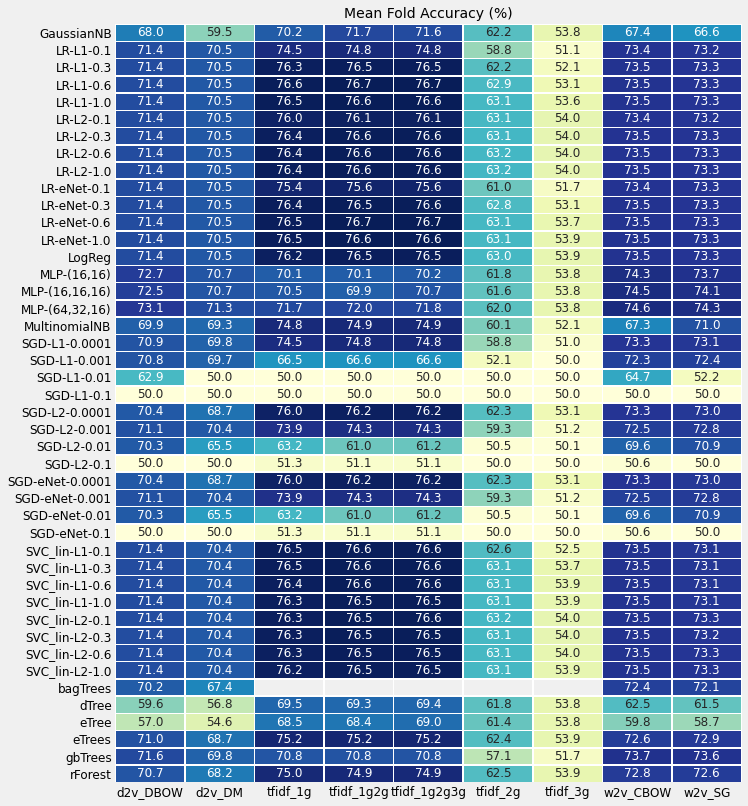

In [40]:
spotcheck_mean_acc = spotcheck_results.applymap(lambda x: np.mean(x)*100)

plt.figure(figsize=(10,13))
ax = sns.heatmap(spotcheck_mean_acc, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1f",  cbar=False)
ax.set_title('Mean Fold Accuracy (%)', fontsize='14');

Из тепловой карты перекрестно-проверенных средних оценок точности наблюдаются следующие закономерности:
- Линейные классификаторы превосходят нелинейные алгоритмы, когда используется характеристика tf-idf.
- word2vec довольно хорошо работает для MLPs и градиентных усиленных деревьев
- doc2vec в целом имеет низкую производительность

In [41]:
spotcheck_mean_acc['classifier'] = spotcheck_mean_acc.index

spotcheck_melt = spotcheck_mean_acc.melt(id_vars='classifier',
                                        var_name='feature',
                                        value_name='avg_acc')

# Фильтрация наиболее эффективных алгоритмов
LR_spotcheck = spotcheck_melt[spotcheck_melt['classifier'].str.startswith('LR')]
best_LR = LR_spotcheck.loc[LR_spotcheck['avg_acc'].idxmax()]

SVC_spotcheck = spotcheck_melt[spotcheck_melt['classifier'].str.startswith('SVC')]
best_SVC = SVC_spotcheck.loc[SVC_spotcheck['avg_acc'].idxmax()]

MLP_spotcheck = spotcheck_melt[spotcheck_melt['classifier'].str.startswith('MLP')]
best_MLP = MLP_spotcheck.loc[MLP_spotcheck['avg_acc'].idxmax()]

gbTrees_spotcheck = spotcheck_melt[spotcheck_melt['classifier']=='gbTrees']
best_gbTrees = gbTrees_spotcheck.loc[gbTrees_spotcheck['avg_acc'].idxmax()]

good_spotchecks = pd.DataFrame([best_LR, best_SVC, best_MLP, best_gbTrees]).sort_values(by='avg_acc', ascending=False)
good_spotchecks.reset_index(inplace=True)
good_spotcheck_cv_accs = []
for row in good_spotchecks.iterrows():
    classifier = row[1].loc['classifier']
    feature = row[1].loc['feature']
    good_spotcheck_cv_accs.append(spotcheck_results.loc[classifier, feature] * 100)

good_spotchecks

,index,classifier,feature,avg_acc
0,179,LR-L1-0.6,tfidf_1g2g3g,76.706250
1,163,SVC_lin-L1-0.3,tfidf_1g2g,76.601875
2,324,"MLP-(64,32,16)",w2v_CBOW,74.606250
3,350,gbTrees,w2v_CBOW,73.688750


In [42]:
cv_accs = pd.DataFrame(good_spotcheck_cv_accs)
good_spotchecks_cv_accs = pd.concat([good_spotchecks, cv_accs], axis=1)
good_spotchecks_cv_accs['classifier & feature'] = good_spotchecks['classifier'] + ' + ' + good_spotchecks['feature']
good_spotchecks_cv_accs.drop(['index', 'classifier', 'feature', 'avg_acc'], axis=1, inplace=True)

good_spotchecks_cv_accs = good_spotchecks_cv_accs.melt(id_vars='classifier & feature',
                                                       var_name = 'Fold',
                                                       value_name='Fold Accuracy')

good_spotchecks_cv_accs.sort_values(['classifier & feature','Fold'], inplace=True)
good_spotchecks_cv_accs

,classifier & feature,Fold,Fold Accuracy
0,LR-L1-0.6 + tfidf_1g2g3g,0,0.766075
4,LR-L1-0.6 + tfidf_1g2g3g,1,0.770700
8,LR-L1-0.6 + tfidf_1g2g3g,2,0.766950
12,LR-L1-0.6 + tfidf_1g2g3g,3,0.764525
16,LR-L1-0.6 + tfidf_1g2g3g,4,0.766075
20,LR-L1-0.6 + tfidf_1g2g3g,5,0.770700
24,LR-L1-0.6 + tfidf_1g2g3g,6,0.766950
...,...,...,...
1575,gbTrees + w2v_CBOW,393,0.741525
1579,gbTrees + w2v_CBOW,394,0.732700


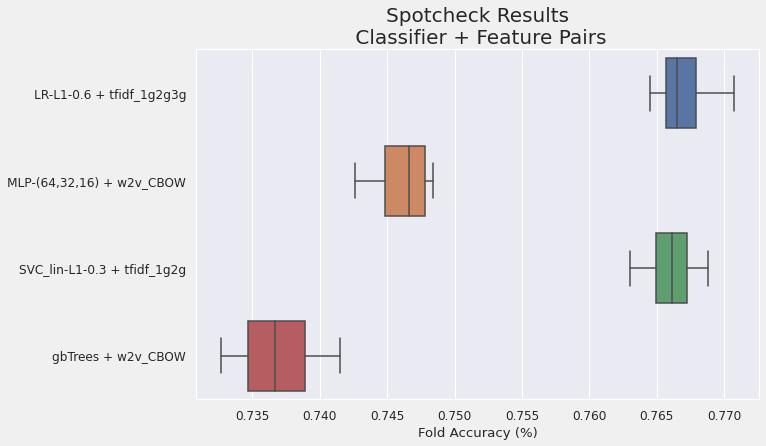

In [43]:
# Boxplots Cross-val accuracies
plt.figure(figsize=(9,6))
sns.set(font_scale = 1.1)
ax = sns.boxplot(y='classifier & feature', x="Fold Accuracy", data=good_spotchecks_cv_accs)
ax.set_xlabel('Fold Accuracy (%)')
ax.set_ylabel('')
ax.set_title('Spotcheck Results\n Classifier + Feature Pairs', fontsize=20)
plt.show()

Из представленных результатов следует, что наибольшей точности достигают классификаторы логистической регрессии и опорных векторов. Но нейронные сети и алгоритмы градиентных усиленных деревьев заслуживают более детального изучения, поскольку их производительность сильно зависит от выбора архитектуры и гиперпараметров.

Более подробно будет исследовано следующее:
- Настройка линейного классификатора на характеристики tf-idf (до 3 grams). Включает в себя выбор параметров для характеристики, метод масштабирования объектов, метод выбора объектов и гиперпараметры модели.
- [pre-trained GloVe word embeddings](https://nlp.stanford.edu/projects/glove/) по твитам
- Настройка градиентных усиленных гиперпараметров деревьев с word embeddings (word2vec / GloVe).
- Эксперимент с различными архитектурами сверточных нейронных сетей (CNN) наряду с word embeddings (word2vec/GloVe/embedding_input_layer).

### Настройка линейного классификатора
Основываясь на их базовой производительности, надо обучать логистический классификатор с функциями tf-idf (вплоть до trigrams включительно). Поскольку производительность модели зависит от выбора заметных объектов, параметров, управляющих количеством объектов, масштабированием, они будут настраиваться в дополнение к гиперпараметрам модели.

In [44]:
#~~~~~~~~~~~~| Lasso Regression (L1 penalty)|~~~~~~~~~~~~#
# Optimize tf-idf vectorizer
max_features_ = [3000, 10000, 50000, 100000]
val_accs_lr_tfidf = []
save_as = 'misc/val_accs_lr_tfidf.pkl'

try:
    with open(save_as, 'rb') as f:
        val_accs_lr_tfidf = pickle.load(f)

except (FileNotFoundError, EOFError):
    for max_f in tqdm(max_features_):  
        tfidf_vectorizer = TfidfVectorizer(
            min_df=5,
            max_features=max_f,
            ngram_range=(1,3)
        )

        lr = LogisticRegression(penalty='l1', C=0.6, solver='saga', max_iter=200,
                                random_state=181, n_jobs=-1)
        
        pipeSteps = []
        pipeSteps.append(('tfidf', tfidf_vectorizer))
        pipeSteps.append(('normalize', MaxAbsScaler())) #Scaler can be applied to Sparse; similar to minmax for pos values
        pipeSteps.append(('model', lr))
        pipeline = Pipeline(pipeSteps)
        val_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        val_accs_lr_tfidf.append(np.mean(val_scores))
    
    with open(save_as, 'wb') as f:
        pickle.dump(val_accs_lr_tfidf, f)

In [45]:
print(*val_accs_lr_tfidf)

0.7666124999999999 0.77378125 0.77431875 0.77431875


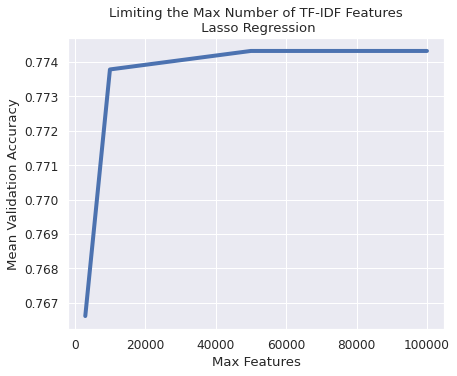

In [46]:
plt.figure(figsize=(6,5))
plt.plot(max_features_, val_accs_lr_tfidf, lw=4)
plt.title('Limiting the Max Number of TF-IDF Features\n Lasso Regression')
plt.xlabel('Max Features')
plt.ylabel('Mean Validation Accuracy')
plt.show()

Похоже, что, включив больше функций, можно добиться небольшого повышения точности на 1%. Точность не улучшается за пределами установки 50000 в качестве максимального числа объектов tf-idf, поэтому надо использовать его в качестве предела при выборе функции масштабирования.

In [47]:
#~~~~~~~~~~| Выбор фунции масштабирования|~~~~~~~~~~~~~#

# поддерживает разреженный ввод
scalers = {'MaxAbs': MaxAbsScaler(),
           'Standard': StandardScaler(with_mean=False),
           'Robust': RobustScaler(with_centering=False)}

scaler_names = sorted(scalers.keys())
val_accs_lr_scaler = []
save_as = 'misc/val_accs_lr_scaler.pkl'

try:
    with open(save_as, 'rb') as f:
        val_accs_lr_scaler = pickle.load(f)
    
except (FileNotFoundError, EOFError):
    for name, scaler in tqdm(sorted(scalers.items())):
        lr = LogisticRegression(penalty='l1', C=0.6, solver='saga', max_iter=200,
                                random_state=181, n_jobs=-1)
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=50000, ngram_range=(1,3))
        pipeSteps = []
        pipeSteps.append(('tfidf', tfidf_vectorizer))
        pipeSteps.append((name, scaler))
        pipeSteps.append(('model', lr))
        pipeline = Pipeline(pipeSteps)

        val_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        val_accs_lr_scaler.append(np.mean(val_scores))

    with open(save_as, 'wb') as f:
        pickle.dump(val_accs_lr_scaler, f)


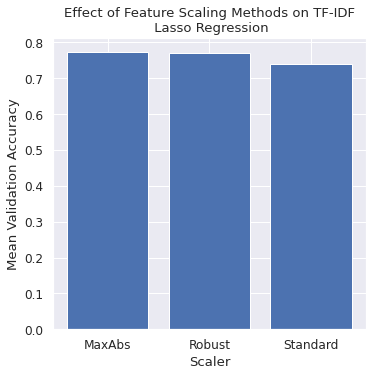

In [48]:
plt.figure(figsize=(5,5))
plt.bar(scaler_names, val_accs_lr_scaler)
plt.title('Effect of Feature Scaling Methods on TF-IDF\n Lasso Regression')
plt.xlabel('Scaler')
plt.ylabel('Mean Validation Accuracy');

Результаты показывают, что `MaxAbsScaler` дает самую высокую точность.

Далее надо исследовать влияние различных методов масштабирования объектов. В sklearn два метода выбора признаков, которые обеспечивают поддержку разреженных матричных данных в задачах классификации, - это `chi2` и `mutual_info_classif`. Оба измеряют зависимость между двумя случайными переменными (объект и целевая переменная), что позволяет выбрать объекты, дающие самые высокие баллы. Оба метода выбора объектов сравниваются со случаем простого ограничения количества объектов tf-idf во время векторизации.

In [49]:
#~~~~~~~~~~| Выбор метода выбора признаков|~~~~~~~~~~~~~#
feature_limits = np.arange(10000,110000,10000)
save_as = 'misc/feature_select_lr_accs.csv'

try:
    feature_select_accs = pd.read_csv(save_as)

except FileNotFoundError:
    tfidf_accs = []
    chi2_accs = []
    mutualInfo_accs = []
    for lim in tqdm(feature_limits):
        lr = LogisticRegression(penalty='l1', C=0.6, solver='saga', max_iter=200,
                                random_state=181, n_jobs=-1)

        scaler = MaxAbsScaler()

        # TF-IDF ограничение функций
        tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=lim, ngram_range=(1,3))

        pipeSteps = []
        pipeSteps.append(('tfidf', tfidf_vectorizer))
        pipeSteps.append(('scaler', scaler))
        pipeSteps.append(('model', lr))
        tfidf_pipe = Pipeline(pipeSteps)

        tfidf_val_scores = cross_val_score(tfidf_pipe, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        tfidf_mean_acc = np.mean(tfidf_val_scores)
        tfidf_accs.append(tfidf_mean_acc)

        # Chi2
        tfidf_all = TfidfVectorizer(min_df=2, ngram_range=(1,3))

        chi2_pipe = Pipeline([
            ('tfidf', tfidf_all),
            ('scaler', scaler),
            ('feat_selection', SelectKBest(chi2, k=lim)),
            ('model', lr)
        ])
        chi2_val_scores = cross_val_score(chi2_pipe, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        chi2_mean_acc = np.mean(chi2_val_scores)
        chi2_accs.append(chi2_mean_acc)

        # Mutual Info
        MI_pipe = Pipeline([
            ('tfidf', tfidf_all),
            ('scaler', scaler),
            ('feat_selection', SelectKBest(mutual_info_classif, k=lim)),
            ('model', lr)
        ])
        MI_val_scores = cross_val_score(MI_pipe, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        MI_mean_acc = np.mean(MI_val_scores)
        mutualInfo_accs.append(MI_mean_acc)

    feature_select_accs = pd.DataFrame({
        'Number of Limited Features': feature_limits,
        'tf-idf':tfidf_accs,
        'chi2':chi2_accs,
        'mutual info':mutualInfo_accs
    })

    feature_select_accs.to_csv(save_as)

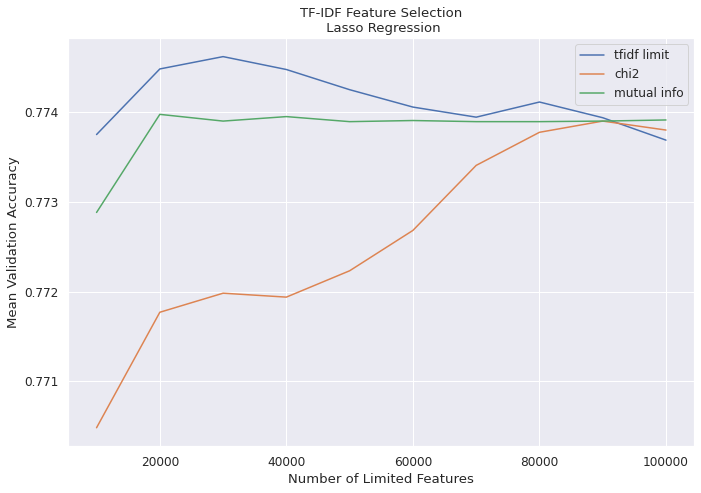

In [50]:
plt.figure(figsize=(10,7))
plt.plot(feature_select_accs['Number of Limited Features'], feature_select_accs['tf-idf'], label='tfidf limit')
plt.plot(feature_select_accs['Number of Limited Features'], feature_select_accs['chi2'],   label='chi2')
plt.plot(feature_select_accs['Number of Limited Features'], feature_select_accs['mutual info'], label='mutual info')
plt.title('TF-IDF Feature Selection\n Lasso Regression')
plt.xlabel('Number of Limited Features')
plt.ylabel('Mean Validation Accuracy')
plt.legend();

Из графика мы видим, что простое ограничение числа признаков до 30000 наиболее часто встречающихся grams дает наилучшую точность. В данном случае методы выбора объектов эффективны только за пределами 90000 объектов.

In [80]:
#~~~~~~~~~~~| Настройка параметров модели |~~~~~~~~~~~#
fileName = 'models/lr_final.pkl'
try:
    lr_final = joblib.load(fileName);
    
except FileNotFoundError:
    tfidf_vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,3))
    scaler = MaxAbsScaler()
    clf = LogisticRegression(penalty='l1', solver='saga', max_iter=200, n_jobs=-1)

    lr_tune_pipe = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('maxAbs', scaler),
        ('lr', clf)
    ])

    param_grid = {
        'tfidf__min_df':[2,3],
        'lr__C':np.arange(0.55, 0.85, 0.05)
    }

    lr_final = GridSearchCV(lr_tune_pipe, param_grid, scoring='accuracy', cv=4,
                           n_jobs=-1, verbose=2)

    lr_final.fit(X_train, y_train)
    joblib.dump(lr_final, fileName)

/home/artem/.local/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/artem/.local/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/artem/.local/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MaxAbsScaler from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/artem/.local/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.23.1. This might lead to breaking code or i

Best-Found Logistic Regression: Generic tweet test set 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

best hyperparameters: {'lr__C': 0.8000000000000003, 'tfidf__min_df': 3}
k-fold validation acc: 77.57%
test acc: 77.75%
ROC AUC:  0.78
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     20000
           4       0.76      0.81      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



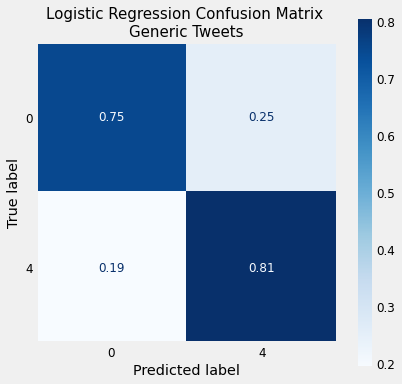

In [81]:
## Статистика эффективности логистической регрессии на тестовом наборе всех твитов
print('Best-Found Logistic Regression: Generic tweet test set \n'+'~'*70+'\n')
print('best hyperparameters:',  lr_final.best_params_)
print(f'k-fold validation acc: {lr_final.best_score_:.2%}')
lr_test_preds = lr_final.predict(X_test)
lr_testacc_generic = accuracy_score(y_test, lr_test_preds)
auc_lr_generic     = roc_auc_score(y_test,lr_test_preds)
print(f'test acc: {lr_testacc_generic:.2%}')
print(f'ROC AUC:  {auc_lr_generic:.2}')
print(classification_report(y_test,lr_test_preds))

fig, ax = plt.subplots(figsize=(6,6))
lr_cm = plot_confusion_matrix(lr_final, X_test, y_test,
                              cmap=plt.cm.Blues,normalize='true', ax=ax)

lr_cm.ax_.set_title('Logistic Regression Confusion Matrix \nGeneric Tweets', fontsize=15)
plt.grid(False)
plt.show()

Best-Found Logistic Regression: Airline tweet test set 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

test acc: 76.07%
ROC AUC:  0.81
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      9178
           4       0.46      0.89      0.60      2363

    accuracy                           0.76     11541
   macro avg       0.71      0.81      0.72     11541
weighted avg       0.86      0.76      0.78     11541



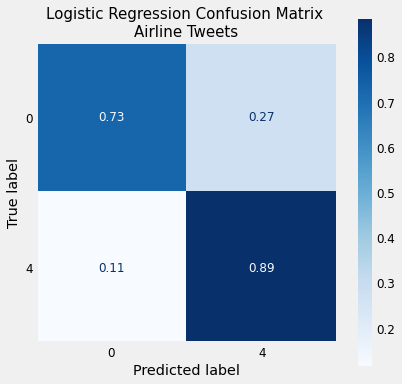

In [82]:
## Статистика эффективности логистической регрессии на тестовом наборе авиакомпаний
print('Best-Found Logistic Regression: Airline tweet test set \n'+'~'*70+'\n')

X_test_airline = airline_df['cleantext']
y_test_airline = airline_df['class']

lr_test_preds = lr_final.predict(X_test_airline)
lr_testacc_airline = accuracy_score(y_test_airline, lr_test_preds)
auc_lr_airline = roc_auc_score(y_test_airline, lr_test_preds)
print(f'test acc: {lr_testacc_airline:.2%}')
print(f'ROC AUC:  {auc_lr_airline:.2}')
print(classification_report(y_test_airline,lr_test_preds))

fig, ax = plt.subplots(figsize=(6,6))

lr_cm = plot_confusion_matrix(lr_final, X_test_airline, y_test_airline,
                              ax=ax,
                              cmap=plt.cm.Blues,
                              normalize='true') #since airline data is imbalanced
lr_cm.ax_.set_title('Logistic Regression Confusion Matrix \nAirline Tweets', fontsize=15)
plt.grid(False)
plt.show()

После выбора наилучшей модели точности теста составила 77,8%, площадь ROC под кривой (AUC) 0,778, F1-оценка ~0,78 для обоих классов в общем наборе тестов.

Производительность этой модели также была проверена на наборе данных твитов авиакомпаний. Видим, что в наборе данных Airline tweet модель логистической регрессии достигает точности 76,1% и ROC AUC 0,808, что довольно хорошо.

Confusion matrix показывает, что классификатор достаточно точно идентифицирует твиты авиакомпаний.  Хорошая F1-оценка - 0.83  достигается для отрицательного класса. Эта модель была бы хороша для авиакомпаний, которые хотели бы эффективно фильтровать новые твиты о жалобах клиентов, поскольку она обеспечивает высокую точность и достойный recall для твитов с негативными настроениями.

### Настройка  Gradient Boosted Trees 
Учитывая, что производительность древовидных моделей обычно очень чувствительна на основе выбранных ими гиперпараметров, тщательная настройка модели xgboost должна потребовать дополнительного исследования, несмотря на то, что она намного хуже линейных моделей с точки зрения точности в базовом тесте. Производительность GBTs будет оцениваться только по характеристикам word embedding, так как ее производительность на tf-idf и doc2vec была низкой.

In [95]:
# word2vec feature transformer
def w2vTransformer(X_untokenized, wordvecs):
    if type(wordvecs) == dict:
        akey = list(wordvecs.keys())[0]
        vec_size = len(wordvecs[akey])        
    else:
        vec_size = wordvecs.vectors.shape[1]
    X_tokenized = X_untokenized.copy().str.split()
    X_transform = X_tokenized.apply(get_mean_wordVec, args=(wordvecs, vec_size))
    X_transform = np.concatenate(X_transform.values)
    return X_transform

In [60]:
## xgboost hyperparameter tuning - 100dim word2vec CBOW
xgb_fileName = 'models/xgb_100d_w2v.pkl'
kv_path      = 'trained_embeddings/w2v_CBOW.kv'
wv = KeyedVectors.load(kv_path, mmap='r')

try:
    xgb_100d_w2v = joblib.load(xgb_fileName)
    
except FileNotFoundError:...
    X_train_100d_w2v = w2vTransformer(X_train, wv)
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300],
        'learning_rate': np.linspace(0.05, 0.2, 11),
        'max_depth': np.arange(4, 16),
        'subsample': np.linspace(0.6, 1, 11),
        'colsample_bytree': np.linspace(0.6, 0.9, 11),
        'gamma': [0, 0.025, 0.050, 0.075, 0.1],
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 5, 10, 100],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 5, 10, 100]
    }
    
    xgb_100d_w2v = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=250,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=3)
    
    xgb_100d_w2v.fit(X_train_100d_w2v, y_train)
    joblib.dump(xgb_100d_w2v, xgb_fileName)

    
print('Best-Found GBT, w2v 100d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb_100d_w2v.best_params_)
print(f'k-fold validation acc: {xgb_100d_w2v.best_score_:.2%}')
X_test_100d_w2v = w2vTransformer(X_test, wv)
xgb_100d_w2v_test_preds = xgb_100d_w2v.predict(X_test_100d_w2v)
xgb_100d_w2v_testacc = accuracy_score(y_test, xgb_100d_w2v_test_preds)
print(f'test acc: {xgb_100d_w2v_testacc:.2%}')
print(f'ROC AUC:  { roc_auc_score(y_test, xgb_100d_w2v_test_preds):.2}')

print(classification_report(y_test, xgb_100d_w2v_test_preds))    

NameError: name 'get_mean_wordVec' is not defined

In [57]:
pd.DataFrame(xgb_100d_w2v.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
17,865.598401,5.178588,1.191268,0.047653,1,100,10,300,13,0.095,0.1,0.6,"{'subsample': 1.0, 'reg_lambda': 100, 'reg_alp...",0.750350,0.754025,0.746800,0.751375,0.750637,0.002590,1
178,757.795356,0.769659,0.929680,0.074256,0.72,100,0.1,250,12,0.11,0.05,0.78,"{'subsample': 0.72, 'reg_lambda': 100, 'reg_al...",0.749325,0.754250,0.747425,0.747775,0.749694,0.002726,2
18,963.610708,3.209394,1.233741,0.148745,0.92,0.1,10,250,14,0.05,0.075,0.78,"{'subsample': 0.9199999999999999, 'reg_lambda'...",0.749675,0.753600,0.746475,0.748825,0.749644,0.002567,3
72,667.691443,6.510147,0.815249,0.107858,0.8,5,10,300,10,0.08,0.05,0.69,"{'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha...",0.749250,0.752000,0.747350,0.749025,0.749406,0.001668,4
43,1077.321373,12.730502,1.302701,0.180766,0.88,1,5,300,12,0.065,0.025,0.87,"{'subsample': 0.88, 'reg_lambda': 1, 'reg_alph...",0.749775,0.752500,0.745400,0.749900,0.749394,0.002550,5


С помощью настройки гиперпараметра можно достичь точности валидации 0,75, что является большим улучшением по сравнению с ненастроенной моделью. 

In [ ]:
## xgboost hyperparameter tuning (finer tuning) - 100dim word2vec CBOW
xgb2_fileName = 'models/xgb2_100d_w2v.pkl'
kv_path = 'trained_embeddings/w2v_CBOW.kv'
wv = KeyedVectors.load(kv_path, mmap='r')

try:
    xgb2_100d_w2v = joblib.load(xgb2_fileName)
    
except FileNotFoundError:
    X_train_100d_w2v = w2vTransformer(X_train, wv)
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators': [300, 400, 500, 600, 700],
        'learning_rate': np.linspace(0.01, 0.1, 11),
        'max_depth': np.arange(10, 17),
        'subsample': np.linspace(0.8, 1, 11),
        'colsample_bytree': np.linspace(0.6, 0.8, 11),
        'gamma': np.linspace(0.05, 0.2, 11),
        'reg_alpha': np.linspace(0.1, 20, 11),
        'reg_lambda': np.linspace(0.1, 150, 21)
    }
    
    xgb2_100d_w2v = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=80,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=4)
    
    xgb2_100d_w2v.fit(X_train_100d_w2v, y_train)
    joblib.dump(xgb2_100d_w2v, xgb2_fileName)
    

print('Best-Found GBT, w2v 100d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb2_100d_w2v.best_params_)
print('k-fold validation acc:', xgb2_100d_w2v.best_score_)
X_test_100d_w2v = w2vTransformer(X_test, wv)
xgb2_100d_w2v_test_preds = xgb2_100d_w2v.predict(X_test_100d_w2v)
xgb2_100d_w2v_testacc = accuracy_score(y_test, xgb2_100d_w2v_test_preds)
print('test acc:', xgb2_100d_w2v_testacc)
print('ROC AUC:', roc_auc_score(y_test, xgb2_100d_w2v_test_preds))
print(classification_report(y_test, xgb2_100d_w2v_test_preds))

Использование более чем двукратного числа оценщиков позволяет GBT добиться незначительного повышения производительности, однако он все еще не может превзойти модель логистической регрессии. Увеличение числа оценок сверх этого было бы слишком дорогостоящим с точки зрения вычислительных ресурсов.

#### GloVe 100d
В качестве альтернативы word2vec embeddings можно оценить производительность 100-мерных GloVe embeddings, предварительно обученных на твитах.

In [59]:
### Import GloVe 100 dim
glove100_wv = {}   #Maps GloVe tokens to embedding vecs
glove100_path = '\glove.twitter.27B.100d.txt'

with open(glove100_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        wordVec =  np.asarray(values[1:], dtype='float32')
        glove100_wv[word] = wordVec

print('Number of word vectors: ', len(glove100_wv))

X_train_100d_glv = w2vTransformer(X_train, glove100_wv)

print(X_train_100d_glv.shape)

Number of word vectors:  1193514
(160000, 100)


In [7]:
## xgboost - 100dim GLoVe
xgb_fileName = 'models/xgb_100d_glv.pkl'

try:
    xgb_100d_glv = joblib.load(xgb_fileName)
    
except FileNotFoundError:
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators': [200, 300, 400, 500, 600],
        'learning_rate': np.linspace(0.01, 0.1, 11),
        'max_depth': np.arange(8, 17),
        'subsample': np.linspace(0.7, 0.9, 11),
        'colsample_bytree': np.linspace(0.6, 0.9, 11),
        'gamma': np.linspace(0, 0.2, 21),
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
    }
    
    xgb_100d_glv = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=100,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=10)
    
    xgb_100d_glv.fit(X_train_100d_glv, y_train)
    joblib.dump(xgb_100d_glv, xgb_fileName)
    

print('Best-Found GBT, GloVe 100d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb_100d_glv.best_params_)
print('k-fold validation acc:', xgb_100d_glv.best_score_)
X_test_100d_glv = w2vTransformer(X_test, glove100_wv)
xgb_100d_glv_test_preds = xgb_100d_glv.predict(X_test_100d_glv)
xgb_100d_glv_testacc = accuracy_score(y_test, xgb_100d_glv_test_preds)
print('test acc:', xgb_100d_glv_testacc)
print('ROC AUC:', roc_auc_score(y_test, xgb_100d_glv_test_preds))
print(classification_report(y_test, xgb_100d_glv_test_preds))


XGBoostError: [18:08:40] /workspace/src/learner.cc:846: Check failed: header == serialisation_header_: 

  If you are loading a serialized model (like pickle in Python) generated by older
  XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version.  There's a simple script for helping
  the process. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for reference to the script, and more details about differences between saving model and
  serializing.


Stack trace:
  [bt] (0) /home/artem/.local/lib/python3.6/site-packages/xgboost/lib/libxgboost.so(+0xa0c64) [0x7f8f39d2dc64]
  [bt] (1) /home/artem/.local/lib/python3.6/site-packages/xgboost/lib/libxgboost.so(+0x1b2d11) [0x7f8f39e3fd11]
  [bt] (2) /home/artem/.local/lib/python3.6/site-packages/xgboost/lib/libxgboost.so(XGBoosterUnserializeFromBuffer+0x4a) [0x7f8f39d1c60a]
  [bt] (3) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f8f9972ddae]
  [bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7f8f9972d71f]
  [bt] (5) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2b4) [0x7f8f999415c4]
  [bt] (6) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x11c33) [0x7f8f99941c33]
  [bt] (7) /usr/bin/python3(_PyObject_FastCallKeywords+0x19c) [0x5a9cbc]
  [bt] (8) /usr/bin/python3() [0x50a5c3]



In [61]:
pd.DataFrame(xgb_100d_glv.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
56,1886.274062,10.980206,1.926816,0.262177,0.82,100,5,600,9,0.055,0.16,0.87,"{'subsample': 0.8200000000000001, 'reg_lambda'...",0.752625,0.755050,0.749600,0.753250,0.752631,0.001964,1
77,3095.857207,30.388187,6.447790,1.498953,0.9,50,0.001,600,14,0.1,0.1,0.78,"{'subsample': 0.9, 'reg_lambda': 50, 'reg_alph...",0.753625,0.755025,0.749175,0.752325,0.752537,0.002163,2
12,2706.880852,19.382256,5.189312,0.206940,0.72,100,1,600,13,0.064,0,0.81,"{'subsample': 0.72, 'reg_lambda': 100, 'reg_al...",0.753825,0.755075,0.750175,0.750525,0.752400,0.002101,3
28,1882.072392,64.049836,3.320710,0.140846,0.9,0.01,10,500,13,0.046,0.08,0.63,"{'subsample': 0.9, 'reg_lambda': 0.01, 'reg_al...",0.752600,0.754400,0.750550,0.750875,0.752106,0.001536,4
2,1782.362378,7.130546,1.608763,0.265378,0.86,1,50,600,11,0.091,0.13,0.75,"{'subsample': 0.86, 'reg_lambda': 1, 'reg_alph...",0.754000,0.753550,0.749575,0.750550,0.751919,0.001895,5


#### GloVe 200d

In [66]:
### Import GloVe 200 dim
glove200_wv = {}   #Maps GloVe tokens to embedding vecs
glove200_path = '\glove.twitter.27B.200d.txt'

with open(glove200_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        wordVec =  np.asarray(values[1:], dtype='float32')
        glove200_wv[word] = wordVec

print('Number of word vectors: ', len(glove200_wv))

X_train_200d_glv = w2vTransformer(X_train, glove200_wv)
print(X_train_200d_glv.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Jason\\Documents\\glove_twitter\\glove.twitter.27B.200d.txt'

In [63]:
## xgboost hyperparameter tuning - 200dim GLoVe
xgb_fileName = os.path.join(pwd, 'models', 'xgb_200d_glv.pkl')

try:
    xgb_200d_glv = joblib.load(xgb_fileName)
    
except FileNotFoundError:
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators' : [600, 700],
        'learning_rate': np.linspace(0.01, 0.1, 11),
        'max_depth': np.arange(7, 15),
        'subsample': np.linspace(0.7, 0.9, 11),
        'colsample_bytree': np.linspace(0.6, 0.9, 11),
        'gamma': np.linspace(0, 0.2, 21),
        'reg_alpha' : [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
    }
    
    xgb_200d_glv = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=60,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=10)
    
    xgb_200d_glv.fit(X_train_200d_glv, y_train)
    joblib.dump(xgb_200d_glv, xgb_fileName)
    

print('Best-Found GBT, GloVe 200d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb_200d_glv.best_params_)
print('k-fold validation acc:', xgb_200d_glv.best_score_)
X_test_200d_glv = w2vTransformer(X_test, glove200_wv)
xgb_200d_glv_test_preds = xgb_200d_glv.predict(X_test_200d_glv)
xgb_200d_glv_testacc = accuracy_score(y_test, xgb_200d_glv_test_preds)
print('test acc:', xgb_200d_glv_testacc)
print('ROC AUC:', roc_auc_score(y_test, xgb_200d_glv_test_preds))
print(classification_report(y_test, xgb_200d_glv_test_preds))


Best-Found GBT, GloVe 200d: Generic tweets 
------------------------------------------------------------------------------------------
best hyperparameters: {'subsample': 0.86, 'reg_lambda': 50, 'reg_alpha': 0, 'n_estimators': 600, 'max_depth': 14, 'learning_rate': 0.09100000000000001, 'gamma': 0.09, 'colsample_bytree': 0.78}
k-fold validation acc: 0.76233125
test acc: 0.760625
ROC AUC: 0.7606250000000001
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     20000
           4       0.75      0.77      0.76     20000

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



We find that increasing the dimensionality of the GloVe word embeddings does result in a small boost in test accuracy (76.06%), however we are still unable to outperform our basic logistic regression model.

### 1D настройка ConvNet
Сверточные нейронные сети идеально подходят для решения задачи классификации тональности текста, поскольку они способны извлекать локальную информацию из различных частей текста через локальную связность, присущую их архитектуре. Это позволяет сети извлекать контекстные признаки слова на основе других слов рядом с ними, независимо от расположения слова в последовательности текста.

In [55]:
### 1D ConvNet + word2vec 100d sequential (not flattened with mean operation)
kv_path = 'trained_embeddings/w2v_CBOW.kv'
wv = KeyedVectors.load(kv_path, mmap='r')

# Предварительная обработка данных для ввода в модель keras
max_words = wv.vectors.shape[0]  # Vocab size
val_split = 0.2

tokenizer_w2v100d = Tokenizer(num_words=max_words)
tokenizer_w2v100d.fit_on_texts(X_train.tolist())
sequences = tokenizer_w2v100d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_w2v100d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  # Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
split_idx = int(labels.shape[0] * (1-val_split))
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

# Embedding word2vec weights matrix for embedding layer
embedding_dim = wv.vectors.shape[1]   # размерность 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, seq_idx in word_index.items():
    if seq_idx < max_words:
        try:
            embedding_vec = wv[word]
            embedding_matrix[seq_idx] = embedding_vec
        except KeyError:
            pass  #if word not in vocab

# Standardize embedding matrix
embed_mean = np.mean(embedding_matrix, axis=0)
embed_std = np.std(embedding_matrix, axis=0)
embedding_matrix = (embedding_matrix - embed_mean) / embed_std

embedding_matrix = embedding_matrix.astype('float32')

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


In [56]:
lr = 0.001
es_patience = 10
epochs = 100
batch_sz = 128
model_path = 'models/convNet_w2v100d.h5'
model_history_path = 'models/convNet_w2v100d_history.pkl'

try:
    # Load existing model & training history
    convNet_w2v100d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_w2v100d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    convNet_w2v100d = models.Sequential()
    convNet_w2v100d.add(layers.Embedding(max_words, embedding_dim, input_length=data.shape[1]))
    convNet_w2v100d.add(layers.Dropout(0.5)) 
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.MaxPool1D(2))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Flatten())
    convNet_w2v100d.add(layers.Dense(512, activation='relu'))
    convNet_w2v100d.add(layers.Dense(512, activation='relu'))
    convNet_w2v100d.add(layers.Dropout(0.4))
    convNet_w2v100d.add(layers.Dense(1, activation='sigmoid'))

    # SET weights for embedding layer - already trained w2v
    convNet_w2v100d.layers[0].set_weights([embedding_matrix])
    convNet_w2v100d.layers[0].trainable = False

    print(convNet_w2v100d.summary())
    
    convNet_w2v100d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_w2v100d_history = convNet_w2v100d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_w2v100d_history = convNet_w2v100d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_w2v100d_history, file)

In [57]:
# Plotting function for NN training history
def plot_train_history(history, subtitle=''):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(1, len(acc)+1)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].plot(epochs, acc, 'bo', label='Training acc')
    ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[0].set_title('Accuracy\n'+subtitle)
    ax[0].set_xlabel('Epochs')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Cross-Entropy Loss\n'+subtitle)
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

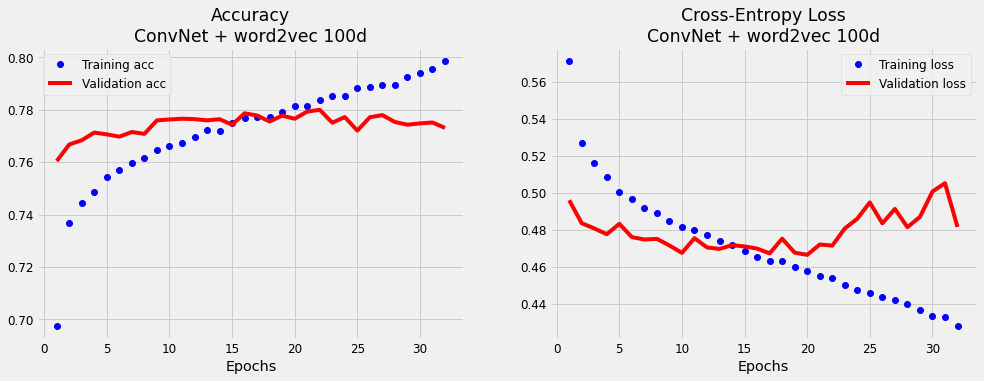

ConvNet, Word2Vec 100d: Generic tweets 
------------------------------------------------------------------------------------------
Validation acc: 0.77996874
test acc: 0.7766000032424927
ROC AUC: 0.7766000000000001
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.78     20000
         1.0       0.78      0.77      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



In [60]:
plot_train_history(convNet_w2v100d_history, subtitle='ConvNet + word2vec 100d')

# Evaluate model on test set
sequences = tokenizer_w2v100d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc = convNet_w2v100d.evaluate(x_tst,y_tst, verbose=0)
test_preds = convNet_w2v100d.predict_classes(x_tst)

print('ConvNet, Word2Vec 100d: Generic tweets \n'+'-'*90)
print('Validation acc:', convNet_w2v100d_history['val_acc'][np.argmax(convNet_w2v100d_history['val_acc'])])
print('test acc:', test_acc)
print('ROC AUC:', roc_auc_score(y_tst, test_preds))
print(classification_report(y_tst, test_preds))

Используя 100D word2vec и архитектуру convnet, мы можно достичь точности 77,66%, что всего на 0,1% ниже, чем у логистической регрессии.

#### GloVe 100d

In [61]:
### 1D ConvNet + GloVe 100d sequential

max_words = 40000  #Vocab size 

tokenizer_glv100d = Tokenizer(num_words=max_words)
tokenizer_glv100d.fit_on_texts(X_train.tolist())
sequences = tokenizer_glv100d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_glv100d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  #Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

# GloVe weights matrix for embedding layer
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, seq_idx in word_index.items():
    if seq_idx < max_words:
        embedding_vec = glove100_wv.get(word)
        if embedding_vec is not None:
            embedding_matrix[seq_idx] = embedding_vec

        
# Standardize embedding matrix
embed_mean = np.mean(embedding_matrix, axis=0)
embed_std = np.std(embedding_matrix, axis=0)
embedding_matrix = (embedding_matrix - embed_mean) / embed_std

embedding_matrix = embedding_matrix.astype('float32')

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


NameError: name 'glove100_wv' is not defined

In [67]:
## Load / Train model 
lr = 0.001
es_patience = 10
epochs = 100
batch_sz = 128
model_path = 'models/convNet_glv100d.h5'
model_history_path = 'models/convNet_glv100d_history.pkl'

try:
    # Load existing model & training history
    convNet_glv100d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_glv100d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    convNet_glv100d = models.Sequential()
    convNet_glv100d.add(layers.Embedding(max_words, embedding_dim, input_length=data.shape[1]))
    convNet_glv100d.add(layers.Dropout(0.5)) 
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.MaxPool1D(2))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Flatten())
    convNet_glv100d.add(layers.Dense(512, activation='relu'))
    convNet_glv100d.add(layers.Dense(512, activation='relu'))
    convNet_glv100d.add(layers.Dropout(0.4))
    convNet_glv100d.add(layers.Dense(1, activation='sigmoid'))

    # SET weights for embedding layer - already trained GloVe
    convNet_glv100d.layers[0].set_weights([embedding_matrix])
    convNet_glv100d.layers[0].trainable = False

    print(convNet_glv100d.summary())
    
    convNet_glv100d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_glv100d_history = convNet_glv100d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_glv100d_history = convNet_glv100d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_glv100d_history, file)

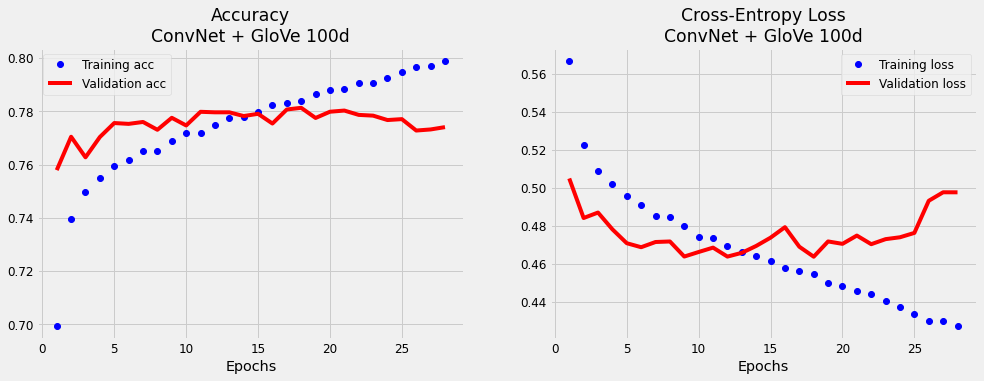

ConvNet, GloVe 100d: Generic tweets 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation acc:78.13%
Test acc:77.99%
ROC AUC: 0.78
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77     20000
         1.0       0.76      0.81      0.79     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



In [50]:
plot_train_history(convNet_glv100d_history, subtitle='ConvNet + GloVe 100d')

# Evaluate model on test set
sequences = tokenizer_glv100d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc = convNet_glv100d.evaluate(x_tst,y_tst, verbose=0)
test_preds = convNet_glv100d.predict_classes(x_tst)


print('ConvNet, GloVe 100d: Generic tweets \n'+'~'*70+'\n')
print(f"Validation acc: {convNet_glv100d_history['val_acc'][np.argmax(convNet_glv100d_history['val_acc'])]:.2%}")
print(f"Test acc: {test_acc:.2%}")
print('ROC AUC:', round(roc_auc_score(y_tst, test_preds),2))
print(classification_report(y_tst, test_preds))

Теперь, используя ту же архитектуру CNN, что и раньше, но вместо этого используя встраивание 100d, наконец-то можно превзойти логистическую регрессию с точностью теста 77,99%.

#### Task specific 100d
Специфическое встраивание задачи включает в себя обучение весов входного embedding layer наряду с остальной частью CNN. Это легко сделать в Keras, указав слой embedding, чтобы позволить его весам быть обучаемыми.

In [62]:
### 1D ConvNet + 100d task-specific embedding w/ embedding layer
max_words = 40000  #Vocab size 

tokenizer_emb100d = Tokenizer(num_words=max_words)
tokenizer_emb100d.fit_on_texts(X_train.tolist())
sequences = tokenizer_emb100d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_emb100d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  #Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


In [63]:
## Load / Train model 
lr = 0.0001
es_patience = 5
epochs = 100
batch_sz = 128
model_path = 'models/convNet_emb100d.h5'
model_history_path = 'models/convNet_emb100d_history.pkl'

try:
    # Load existing model & training history
    convNet_emb100d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_emb100d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    convNet_emb100d = models.Sequential()
    convNet_emb100d.add(layers.Embedding(max_words, 100, input_length=data.shape[1]))
    convNet_emb100d.add(layers.Dropout(0.3)) 
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Dropout(0.3)) 
    convNet_emb100d.add(layers.Flatten())
    convNet_emb100d.add(layers.Dense(256, activation='relu'))
    convNet_emb100d.add(layers.Dense(256, activation='relu'))
    convNet_emb100d.add(layers.Dropout(0.4))
    convNet_emb100d.add(layers.Dense(1, activation='sigmoid'))

    print(convNet_emb100d.summary())
    
    convNet_emb100d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_emb100d_history = convNet_emb100d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_emb100d_history = convNet_emb100d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_emb100d_history, file)

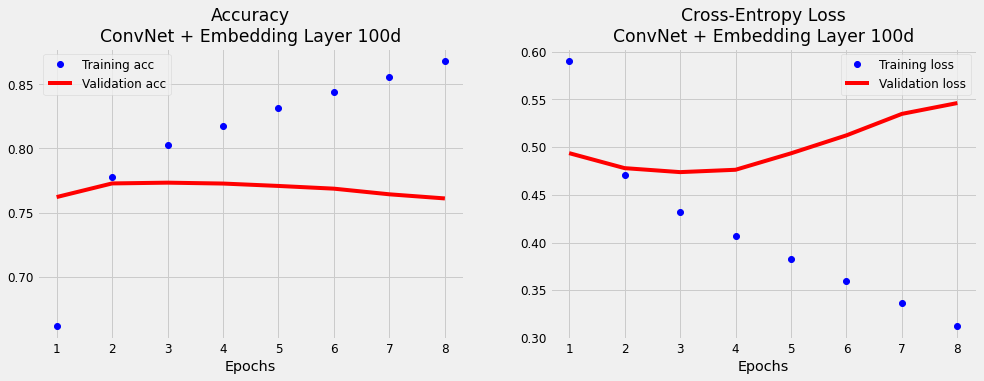

ConvNet, Embedding Layer 100d: Generic tweets 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation acc:77.33%
Test acc:77.12%
ROC AUC: 0.77
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78     20000
         1.0       0.78      0.75      0.77     20000

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



In [64]:
plot_train_history(convNet_emb100d_history, subtitle='ConvNet + Embedding Layer 100d')

# Evaluate model on test set
sequences = tokenizer_emb100d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc = convNet_emb100d.evaluate(x_tst,y_tst, verbose=0)
test_preds = convNet_emb100d.predict_classes(x_tst)

print('ConvNet, Embedding Layer 100d: Generic tweets \n'+'~'*70+'\n')
print(f"Validation acc:{ convNet_emb100d_history['val_acc'][np.argmax(convNet_emb100d_history['val_acc'])]:.2%}")
print(f"Test acc:{test_acc:.2%}")
print('ROC AUC:', round(roc_auc_score(y_tst, test_preds),2))
print(classification_report(y_tst, test_preds))

With a custom Keras embedding layer scheme, we are unable to outperform the linear regression model. This is probably due to there being too many weights to train in order to arrive at very good solution.

#### GloVe 200d
Поскольку GloVe и ConvNets являются лучшим сочетанием до сих пор, попытаемся улучшить прогнозную производительность сети, увеличив размерность GloVe embeddings до 200. Кроме того, вес перчаток не будет заморожен при инициализации, что позволит вносить небольшие изменения веса.

Что касается архитектуры CNN, то она была изменена с последовательной модели на параллельную. Три параллельных разделения рассматривают работу с ядрами размера 2, 3 и 4 отдельно, прежде чем объединять их выходы. Различные размеры ядра позволяют исследовать различные степени детализации контекста в тексте. Модифицированная архитектура также позволяет тренировать меньшие веса с помощью ConvNet, сохраняя при этом хорошую производительность.

In [65]:
### 1D ConvNet + GloVe 200d 
max_words = 40000  #Vocab size 

tokenizer_glv200d = Tokenizer(num_words=max_words)
tokenizer_glv200d.fit_on_texts(X_train.tolist())
sequences = tokenizer_glv200d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_glv200d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  #Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

# GloVe weights matrix for embedding layer
embedding_dim = 200
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, seq_idx in word_index.items():
    if seq_idx < max_words:
        embedding_vec = glove200_wv.get(word)
        if embedding_vec is not None:
            embedding_matrix[seq_idx] = embedding_vec

        
# Standardize embedding matrix
embed_mean = np.mean(embedding_matrix, axis=0)
embed_std = np.std(embedding_matrix, axis=0)
embedding_matrix = (embedding_matrix - embed_mean) / embed_std

embedding_matrix = embedding_matrix.astype('float32')

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


NameError: name 'glove200_wv' is not defined

In [70]:
## Load / Train model 
lr = 0.0003
es_patience = 7
epochs = 100
batch_sz = 64
model_path = 'models/convNet_glv200d.h5'
model_history_path = 'models/convNet_glv200d_history.pkl'

try:
    # Load existing model & training history
    convNet_glv200d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_glv200d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    input_seq = layers.Input(shape=(data.shape[1],), name='input')
    
    embeddings = layers.Embedding(max_words, embedding_dim, input_length=data.shape[1],
                                  weights=[embedding_matrix],
                                  trainable = True)(input_seq)
    
    dropout_emb = layers.Dropout(0.4)(embeddings)
    
    kern_two = layers.Conv1D(64, 2, activation='relu', padding='valid')(dropout_emb)
    kern_two = layers.Conv1D(64, 2, activation='relu', padding='valid')(kern_two)
    maxpool_two = layers.GlobalMaxPooling1D()(kern_two)
    
    kern_three = layers.Conv1D(64, 3, activation='relu', padding='valid')(dropout_emb)
    kern_three = layers.Conv1D(64, 3, activation='relu', padding='valid')(kern_three)
    maxpool_three = layers.GlobalMaxPooling1D()(kern_three)
    
    kern_four = layers.Conv1D(64, 4, activation='relu', padding='valid')(dropout_emb)
    kern_four = layers.Conv1D(64, 4, activation='relu', padding='valid')(kern_four)
    maxpool_four = layers.GlobalMaxPooling1D()(kern_four)
    
    merged = layers.concatenate([maxpool_two, maxpool_three, maxpool_four], axis=1)
    dropout1 = layers.Dropout(0.2)(merged)
    clf = layers.Dense(512, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.2)(clf)
    output = layers.Dense(1, activation='sigmoid')(dropout2)
    
    convNet_glv200d = models.Model(input_seq, output)

    
    print(convNet_glv200d.summary())
    
    convNet_glv200d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_glv200d_history = convNet_glv200d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_glv200d_history = convNet_glv200d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_glv200d_history, file)

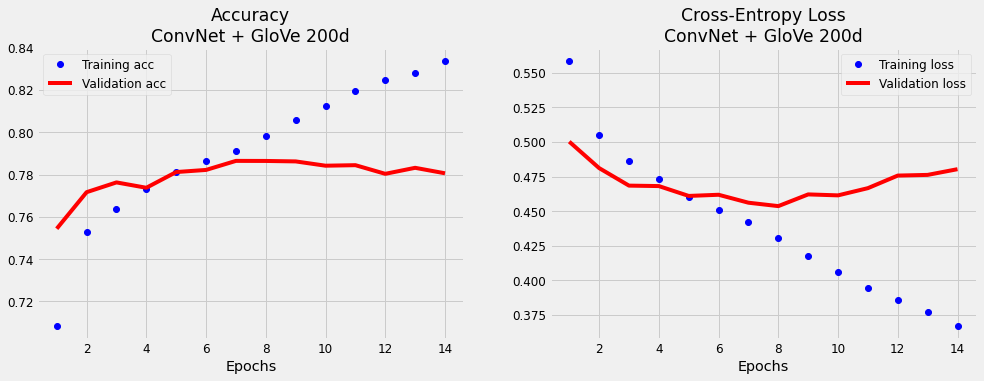

ConvNet, GloVe 200d: Generic tweets 
------------------------------------------------------------------------------------------
Validation acc: 0.78653127
test acc: 0.7846999764442444
ROC AUC: 0.7847
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     20000
         1.0       0.79      0.77      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



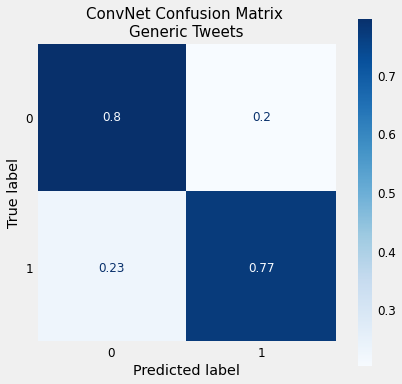

In [77]:
plot_train_history(convNet_glv200d_history, subtitle='ConvNet + GloVe 200d')

# Evaluate model on test set
sequences = tokenizer_glv200d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc_cnn_generic = convNet_glv200d.evaluate(x_tst,y_tst, verbose=0)
test_preds_prob_generic = convNet_glv200d.predict(x_tst)
test_preds = np.copy(test_preds_prob_generic)
test_preds[test_preds_prob_generic > 0.5] = 1
test_preds[test_preds_prob_generic <= 0.5] = 0
auc_cnn_generic = roc_auc_score(y_tst, test_preds)

print('ConvNet, GloVe 200d: Generic tweets \n'+'~'*70+'\n')
print('Validation acc:', convNet_glv200d_history['val_acc'][np.argmax(convNet_glv200d_history['val_acc'])])
print('test acc:', test_acc_cnn_generic)
print('ROC AUC:', auc_cnn_generic)
print(classification_report(y_tst, test_preds))

cnn_vm_vals = confusion_matrix(y_tst, test_preds)
cnn_vm_vals = cnn_vm_vals / np.sum(cnn_vm_vals, axis=1).reshape((-1,1))

cnn_cm = ConfusionMatrixDisplay(cnn_vm_vals)
fig, ax = plt.subplots(figsize=(6,6))
cnn_cm = cnn_cm.plot(cmap=plt.cm.Blues, ax=ax)

cnn_cm.ax_.set_title('ConvNet Confusion Matrix \nGeneric Tweets', fontsize=15)
plt.grid(False)
plt.show()

Используя новую архитектуру CNN наряду с 200d GloVe word embeddings, можно добиться еще одного повышения точности тестирования для общего набора данных 78,47%. Это довольно впечатляюще, учитывая, что классификация настроений текста заведомо сложна, и мы тренируемся только на наборе данных из 160000 твитов. Как и другие проверенные архитектуры нейронных сетей, перенастройка сети была серьезной проблемой с таким небольшим набором текстовых данных. В этом случае перенапряжение было смягчено включением нескольких уровней отсева и использованием ранней остановки во время тренировки.

Поскольку идентификация негативных твитов является основной проблемой, эта модель смогла добиться улучшения отзыва на 5% при снижении точности на 1%, улучшив f1-оценку  на 2% по сравнению с лучшей найденной моделью логистической регрессии.

ConvNet, GloVe 200d: Airline tweets 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

test acc: 0.7839008569717407
ROC AUC:  0.8116544309576885
              precision    recall  f1-score   support

         0.0       0.95      0.76      0.85      9178
         1.0       0.48      0.86      0.62      2363

    accuracy                           0.78     11541
   macro avg       0.72      0.81      0.73     11541
weighted avg       0.86      0.78      0.80     11541



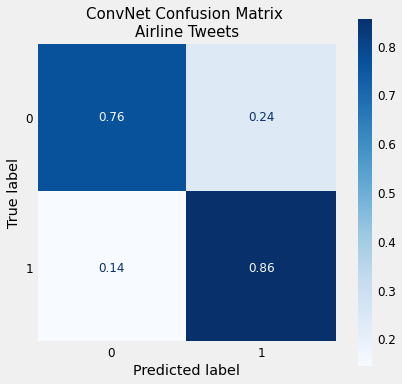

In [84]:
### Статистика производительности ConvNet в тестовом наборе авиакомпаний
sequences = tokenizer_glv200d.texts_to_sequences(X_test_airline.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test_airline.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc_cnn_airline = convNet_glv200d.evaluate(x_tst,y_tst, verbose=0)
test_preds_prob_airline = convNet_glv200d.predict(x_tst)
test_preds = np.copy(test_preds_prob_airline)
test_preds[test_preds_prob_airline > 0.5] = 1
test_preds[test_preds_prob_airline <= 0.5] = 0
auc_cnn_airline = roc_auc_score(y_tst, test_preds)

print('ConvNet, GloVe 200d: Airline tweets \n'+'~'*70+'\n')
print('test acc:', test_acc_cnn_airline)
print('ROC AUC: ', auc_cnn_airline)
print(classification_report(y_tst, test_preds))


cnn_vm_vals = confusion_matrix(y_tst, test_preds)
cnn_vm_vals = cnn_vm_vals / np.sum(cnn_vm_vals, axis=1).reshape((-1,1)) #Normalize for imbalanced data

cnn_cm = ConfusionMatrixDisplay(cnn_vm_vals)
fig, ax = plt.subplots(figsize=(6,6))
cnn_cm = cnn_cm.plot(cmap=plt.cm.Blues, ax=ax)

cnn_cm.ax_.set_title('ConvNet Confusion Matrix \nAirline Tweets', fontsize=15)
plt.grid(False)
plt.show()

Аналогичная тенденция наблюдается и в тестовом наборе несбалансированных твитов авиакомпаний, где наблюдается увеличение отзыва на 3% при снижении точности отрицательных твитов на 1% относительно наилучшей найденной линейной регрессионной модели. Модель CNN также сохраняет свой высокий балл точности 78,39% , что еще раз подтверждает, что модель не является чрезмерно переобученной и является наиболее эффективным классификатором.

## Лучший классификатор, резюме
Чтобы обобщить выводы, можно сравнить ROC кривые и оценки точности наиболее эффективной ConvNet с лучшим найденным линейным классификатором.

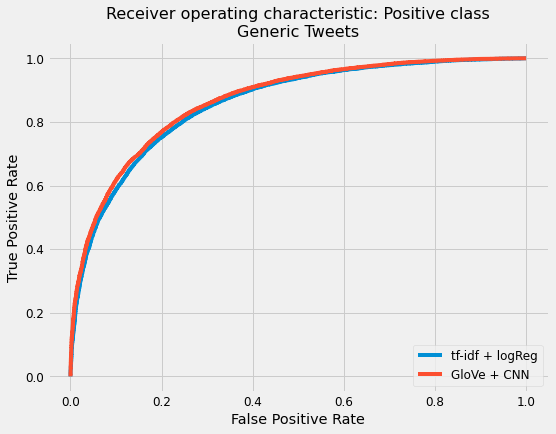

,ROC AUC (%),Test Accuracy (%)
tf-idf + logReg,77.75,77.75
GloVe + CNN,78.47,78.47


In [85]:
# Generic dataset summary stats
plt.figure(figsize=(8,6))
lr_test_preds_prob_generic = lr_final.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_test_preds_prob_generic, pos_label=4)
plt.plot(fpr_lr, tpr_lr, label='tf-idf + logReg')
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, test_preds_prob_generic, pos_label=4)
plt.plot(fpr_cnn, tpr_cnn, label='GloVe + CNN')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Positive class\nGeneric Tweets', fontsize=16)
plt.show()

generic_summary = {'ROC AUC (%)':[auc_lr_generic, auc_cnn_generic],
                   'Test Accuracy (%)':[lr_testacc_generic, test_acc_cnn_generic]}

generic_summary = pd.DataFrame(generic_summary, index=['tf-idf + logReg', 'GloVe + CNN']).round(4) *100
generic_summary.head()

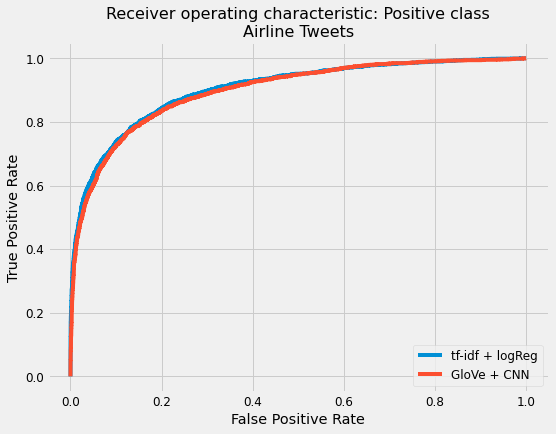

,ROC AUC (%),Test Accuracy (%)
tf-idf + logReg,80.76,76.07
GloVe + CNN,81.17,78.39


In [86]:
# Airline dataset summary stats
plt.figure(figsize=(8,6))
lr_test_preds_prob_airline = lr_final.predict_proba(X_test_airline)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_airline, lr_test_preds_prob_airline, pos_label=4)
plt.plot(fpr_lr, tpr_lr, label='tf-idf + logReg')

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test_airline, test_preds_prob_airline, pos_label=4)
plt.plot(fpr_cnn, tpr_cnn, label='GloVe + CNN')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Positive class\nAirline Tweets', fontsize=16)
plt.show()

airline_summary = {'ROC AUC (%)':[auc_lr_airline, auc_cnn_airline],
                   'Test Accuracy (%)':[lr_testacc_airline, test_acc_cnn_airline]}

airline_summary = pd.DataFrame(airline_summary, index=['tf-idf + logReg', 'GloVe + CNN']).round(4) *100
airline_summary.head()

Основываясь на графиках ROC и точности тестирования, модель CNN, реализующая 200d GloVe векторы, явно превосходит модель логистической регрессии как для общих, так и для авиационных твитов, основанных на более высокой точности тестирования и площади под ROC.

## Выводы
Общественное мнение в Twitter говорит, что большинство отзывов о американских авиакомпаниях в 2015 году имели негативную коннотацию. Это указывает на то, что клиенты в целом были недовольны обслуживанием американских авиакомпаний в том году. В 2015 году тремя наиболее посещаемыми авиакомпаниями в твиттере были United, US Airways и American Air, в порядке убывания. Быстрый поиск в интернете показывает, что United получила много внимания от общественности из-за инцидентов с обслуживанием клиентов в 2015 году. Судя по жалобам клиентов американских авиакомпаний, наиболее частыми были проблемы с обслуживанием клиентов, за которыми следовали опоздания или отмененные рейсы. Эта информация может служить индикатором того, на чем американская авиакомпания должна сосредоточиться для улучшения своей работы.

Лучшей прогностической моделью для классификации настроений твитов была **convolutional neural net (CNN) leveraging pretrained 200 dimensional GloVe word embeddings.** Эта модель смогла достичь **точности теста ~78.5%**, с **ROC AUC 0.81** на множестве твитов авиакомпании. Точность модели **CNN** можно было бы еще больше повысить путем обучения на основе более широкого набора данных. Это помогло бы предотвратить чрезмерное приспособление, позволяя модели лучше обобщать невидимые данные.